- Electrical Communications Systems
- Final Project
- Fall 2024
- Group 6 - Lauren Eckert, Jaric Abadinas, Ryan Bates, Anthony Alliegro

Topic: Digital Twin of the Radio Environment

- Code from this github: https://github.com/akdd11/dt-radio-environment-novel-approach
- Research from this paper: https://arxiv.org/pdf/2308.06980v2

Implementing their jupyter notebook code to analyze the dataset results:

In [21]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scanf import scanf
import pandas as pd

In [22]:
# Add the parent directory to the system path to import custom modules
module_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.abspath(module_path))

# Import custom utility functions
from src.utils import description_file_utils
from src.utils import radiomap_utils as rmu
from src.utils import pl_utils as plu

In [23]:
# Define the dataset directory
dataset_dir = os.path.join(module_path, 'datasets')
filenames_table = description_file_utils.get_param_by_filename_table('fspl', 'measurements')

# Truncate the filenames by keeping only the base name
filenames_table['filename'] = filenames_table['filename'].apply(os.path.basename)

# Inspect the retrieved table
print(filenames_table)

   noise_std  grid_size  tx_pos_inaccuracy_std             filename
0        0.0       10.0                   1.02   fspl_measurements0
1        2.0       10.0                   1.02   fspl_measurements1
2        2.0        5.0                   1.02  fspl_measurements10
3        2.0       15.0                   1.02  fspl_measurements11
4        2.0       20.0                   1.02  fspl_measurements12
5        4.0       10.0                   1.02   fspl_measurements2
6        6.0       10.0                   1.02   fspl_measurements3
7        8.0       10.0                   1.02   fspl_measurements4
8       10.0       10.0                   1.02   fspl_measurements5


In [24]:
# Define labels for anomaly detection methods
method_labels = {
    'unsupervised_density': 'Unsupervised density',
    'unsupervised_threshold': 'AED',
    'one_class_svm': 'OCSVM',
    'lof': 'LOF',
    'dbscan': 'DBSCAN',
    'elliptic_envelope': 'Elliptic envelope'
}

# Define colors for anomaly detection methods
method_colors = {
    'unsupervised_threshold': 'C0',
    'one_class_svm': 'C1',
    'dbscan': 'C2',
    'lof': 'C3',
    'elliptic_envelope': 'C4',
    'unsupervised_density': 'C5'
}

# Configure Matplotlib settings
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

Single ROC curves + AUC

In [25]:
# Specify which parameter to analyze ('noise_std' or 'grid_size')
param = 'noise_std'

# Methods to exclude from plots
exclude_from_plot = ['unsupervised_density', 'elliptic_envelope', 'dbscan']

# Initialize a dictionary to store AUC values
auc_lists = {method: {} for method in method_labels}

In [26]:
def plot_roc_for_one_config(grid_size, noise_std, ax):
    """
    Plot ROC curve for a single configuration of grid size and noise standard deviation.

    Parameters:
        grid_size (int): Grid size in meters.
        noise_std (float): Noise standard deviation in dB.
        ax (matplotlib.axes.Axes): Axis on which to plot the ROC curve.
    """
    # Load the results for the specific configuration
    filename = filenames_table.loc[
        np.logical_and(filenames_table['noise_std'] == noise_std, filenames_table['grid_size'] == grid_size), 
        'filename'
    ].values[0]
    dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]
    with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
        results = pickle.load(f_results)

    # Plot ROC curves for all methods
    for method in results:
        if method in exclude_from_plot:
            continue

        # Calculate ROC curve and AUC
        y_test = results[method]['y_test']
        y_hat = results[method]['y_hat']
        if method == 'one_class_svm':
            fpr, tpr, thresholds = roc_curve(y_test, -y_hat)
            auc = roc_auc_score(y_test, 1 - y_hat)
        else:
            fpr, tpr, thresholds = roc_curve(y_test, y_hat)
            auc = roc_auc_score(y_test, y_hat)

        # Store AUC in the dictionary
        key = noise_std if param == 'noise_std' else grid_size
        auc_lists[method][key] = auc

        # Plot the ROC curve
        ax.plot(fpr, tpr, color=method_colors[method], label=f'{method_labels[method]} (AUC: {auc:.3f})')

    # Plot the baseline (random guess)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')

    # Configure the plot
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_title(f'ROC curve (grid size: {grid_size}m, noise std: {noise_std}dB)')
    ax.grid()

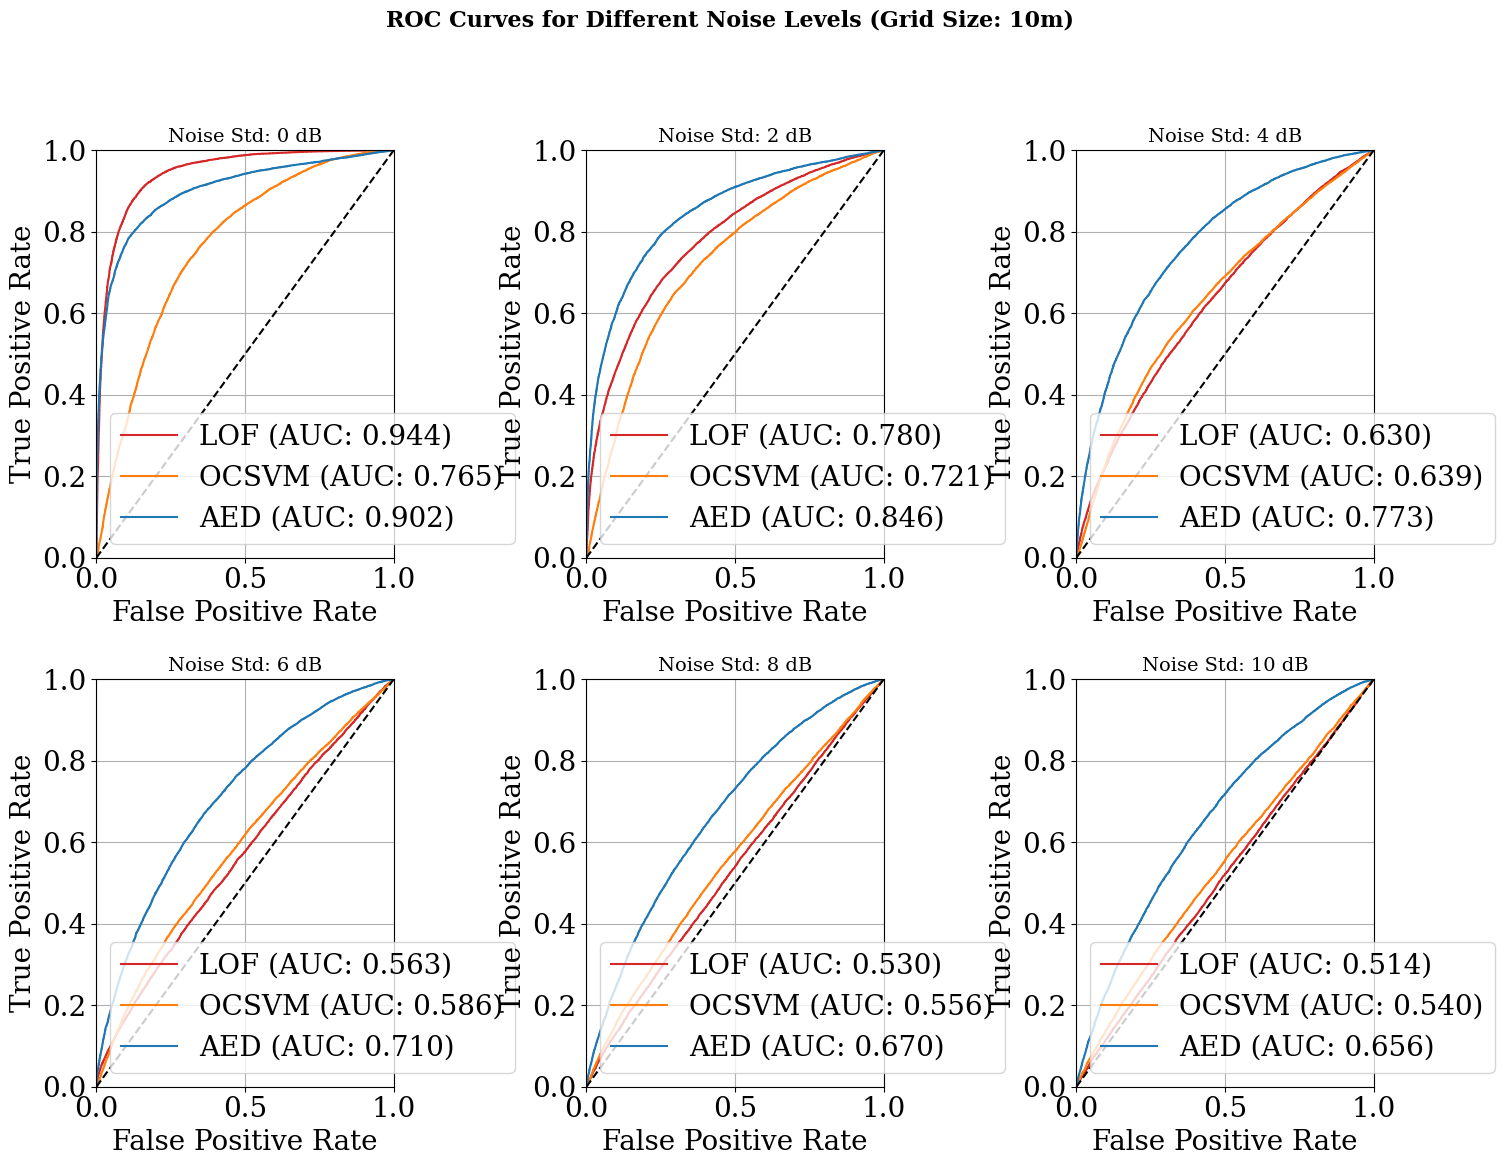

In [27]:
if param == 'noise_std':
    fig, ax = plt.subplots(2, 3, figsize=(15, 12))  # Adjust figure size for better spacing
    for ax_idx, noise_std in enumerate(np.arange(0, 11, 2)):
        row, col = divmod(ax_idx, 3)  # Compute subplot position
        plot_roc_for_one_config(10, noise_std, ax[row, col])  # Plot ROC for the current noise_std
        ax[row, col].set_title(f"Noise Std: {noise_std} dB", fontsize=14)  # Add descriptive titles

    # Adjust spacing and add a main title
    fig.suptitle("ROC Curves for Different Noise Levels (Grid Size: 10m)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()
elif param == 'grid_size':
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))  # Adjust figure size for better spacing
    for ax_idx, grid_size in enumerate(np.arange(5, 25, 5)):
        row, col = divmod(ax_idx, 2)  # Compute subplot position
        plot_roc_for_one_config(grid_size, 2, ax[row, col])  # Plot ROC for the current grid size
        ax[row, col].set_title(f"Grid Size: {grid_size} m", fontsize=14)  # Add descriptive titles

    # Adjust spacing and add a main title
    fig.suptitle("ROC Curves for Different Grid Sizes (Noise Std: 2dB)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

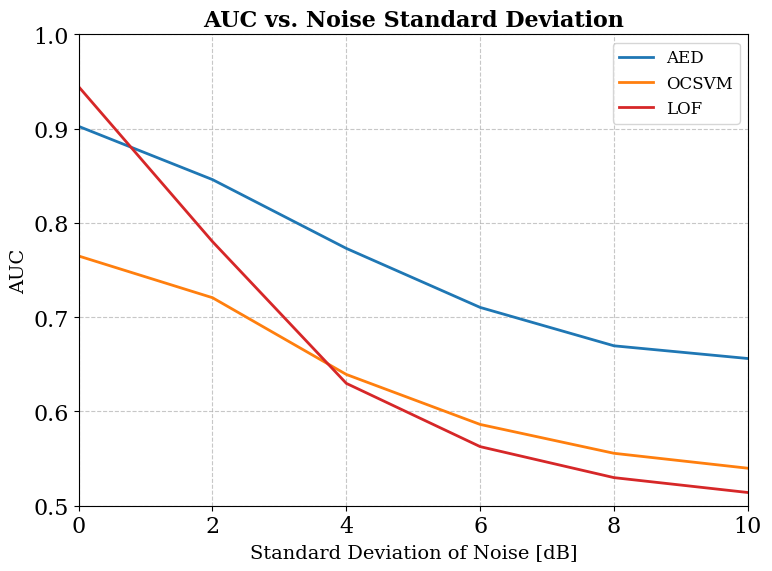

In [28]:
plt.rcParams['font.size'] = 16  # Set font size globally for clarity
plt.figure(figsize=(8, 6))  # Adjust figure size

# Plot AUC for each method
for method in auc_lists:
    if method in exclude_from_plot:
        continue
    plt.plot(
        auc_lists[method].keys(),
        auc_lists[method].values(),
        color=method_colors[method],
        label=method_labels[method],
        linewidth=2,  # Make lines thicker for better visibility
    )

# Add labels and title
plt.xlabel('Standard Deviation of Noise [dB]', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.title('AUC vs. Noise Standard Deviation', fontsize=16, weight='bold')

# Configure axes
plt.xlim([0, 10])
plt.ylim([0.5, 1])
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid with light lines
plt.legend(fontsize=12)  # Adjust legend size
plt.tight_layout()

# Save the plot
figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', f'auc-vs-{param}.pdf')
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

Added some methods to plot the performance by grid size:

In [29]:
def plot_roc_curves_by_grid_size(noise_std, filenames_table, dataset_dir):
    """
    Plot ROC curves for all available grid sizes at a fixed noise standard deviation.

    Parameters:
        noise_std (float): Noise standard deviation to analyze.
        filenames_table (DataFrame): Table containing grid size, noise std, and filenames.
        dataset_dir (str): Directory containing dataset files.
    """
    grid_sizes = filenames_table['grid_size'].unique()  # Get unique grid sizes
    fig, axes = plt.subplots(2, len(grid_sizes) // 2, figsize=(16, 10))
    axes = axes.flatten()  # Flatten axes array for iteration

    for idx, grid_size in enumerate(grid_sizes):
        # Find the file corresponding to this grid size and noise std
        filename = filenames_table.loc[
            (filenames_table['grid_size'] == grid_size) & (filenames_table['noise_std'] == noise_std),
            'filename'
        ].values[0]
        dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]

        with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
            results = pickle.load(f_results)

        ax = axes[idx]
        for method in results:
            if method in exclude_from_plot:
                continue

            y_test = results[method]['y_test']
            y_hat = results[method]['y_hat']
            if method == 'one_class_svm':
                fpr, tpr, _ = roc_curve(y_test, -y_hat)
                auc = roc_auc_score(y_test, 1 - y_hat)
            else:
                fpr, tpr, _ = roc_curve(y_test, y_hat)
                auc = roc_auc_score(y_test, y_hat)

            ax.plot(fpr, tpr, color=method_colors[method], label=f'{method_labels[method]} (AUC: {auc:.3f})')

        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')
        ax.set_title(f'Grid Size: {grid_size}m', fontsize=12)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.grid(True)
        ax.legend(fontsize=10)

    fig.suptitle(f'ROC Curves by Grid Size (Noise Std: {noise_std} dB)', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_auc_vs_grid_size(noise_std, filenames_table, dataset_dir):
    """
    Plot AUC vs. grid size for all methods at a fixed noise standard deviation.

    Parameters:
        noise_std (float): Noise standard deviation to analyze.
        filenames_table (DataFrame): Table containing grid size, noise std, and filenames.
        dataset_dir (str): Directory containing dataset files.
    """
    grid_sizes = filenames_table['grid_size'].unique()  # Get unique grid sizes
    auc_lists = {method: {} for method in method_labels}  # Initialize AUC storage

    for grid_size in grid_sizes:
        # Find the file corresponding to this grid size and noise std
        filename = filenames_table.loc[
            (filenames_table['grid_size'] == grid_size) & (filenames_table['noise_std'] == noise_std),
            'filename'
        ].values[0]
        dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]

        with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
            results = pickle.load(f_results)

        for method in results:
            if method in exclude_from_plot:
                continue

            y_test = results[method]['y_test']
            y_hat = results[method]['y_hat']
            if method == 'one_class_svm':
                auc = roc_auc_score(y_test, 1 - y_hat)
            else:
                auc = roc_auc_score(y_test, y_hat)

            auc_lists[method][grid_size] = auc

    plt.figure(figsize=(8, 6))
    for method in auc_lists:
        if method in exclude_from_plot:
            continue
        plt.plot(
            auc_lists[method].keys(),
            auc_lists[method].values(),
            color=method_colors[method],
            label=method_labels[method],
            linewidth=2,
        )

    plt.title('AUC vs. Grid Size', fontsize=16, weight='bold')
    plt.xlabel('Grid Size [m]', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


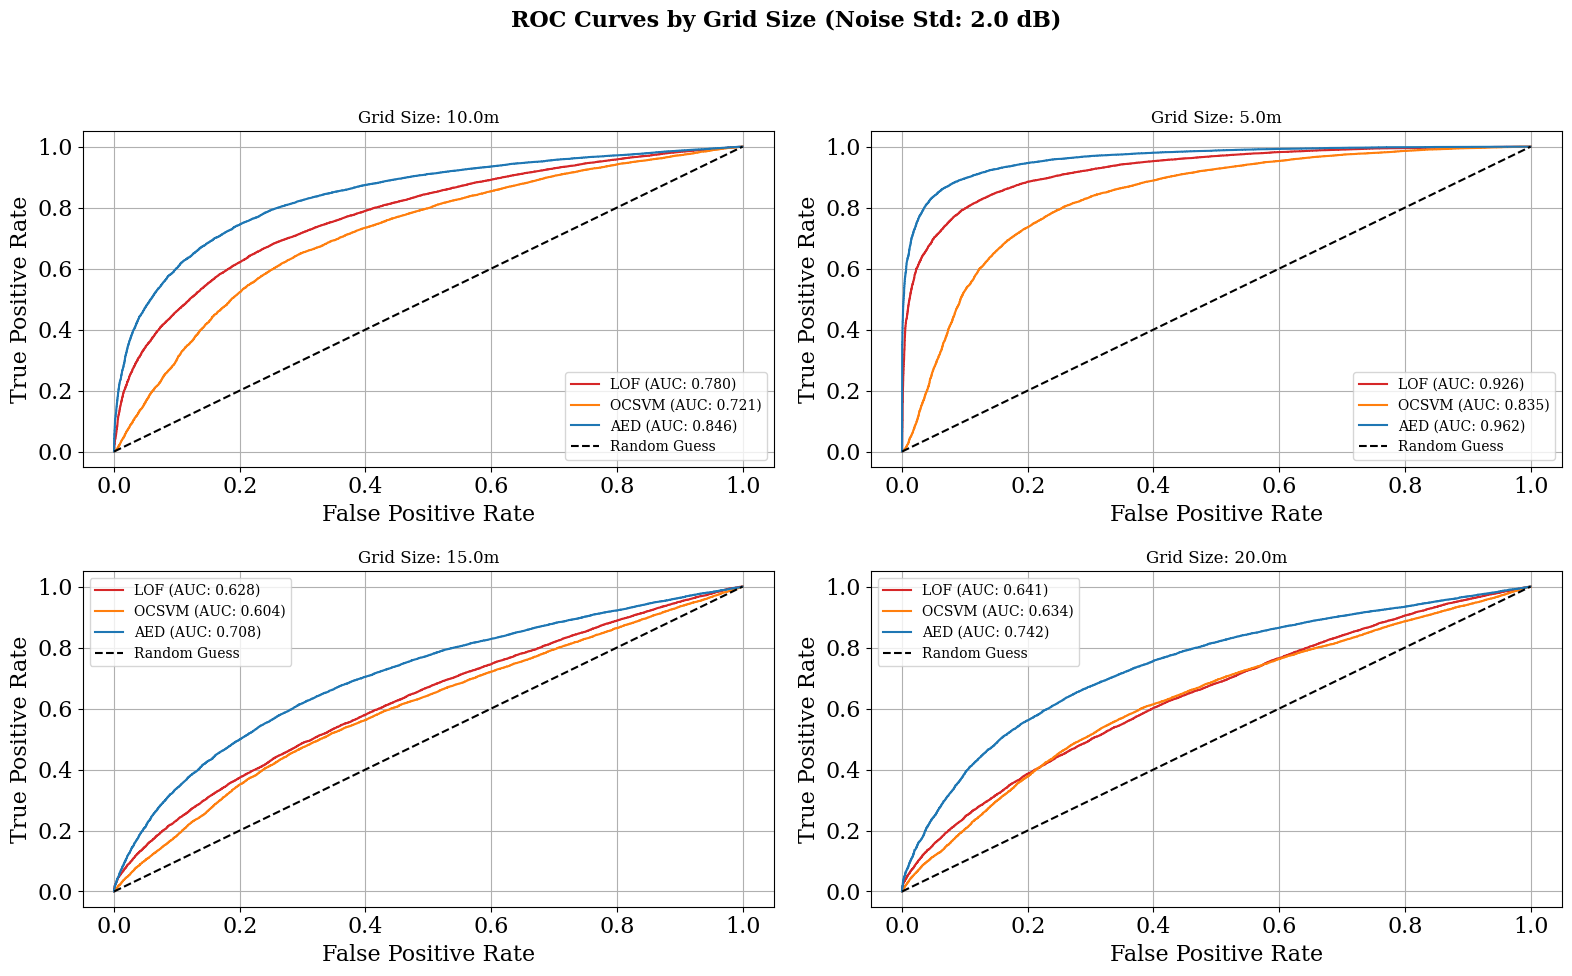

In [30]:
noise_std = 2.0  # Fixed noise standard deviation
plot_roc_curves_by_grid_size(noise_std, filenames_table, dataset_dir)

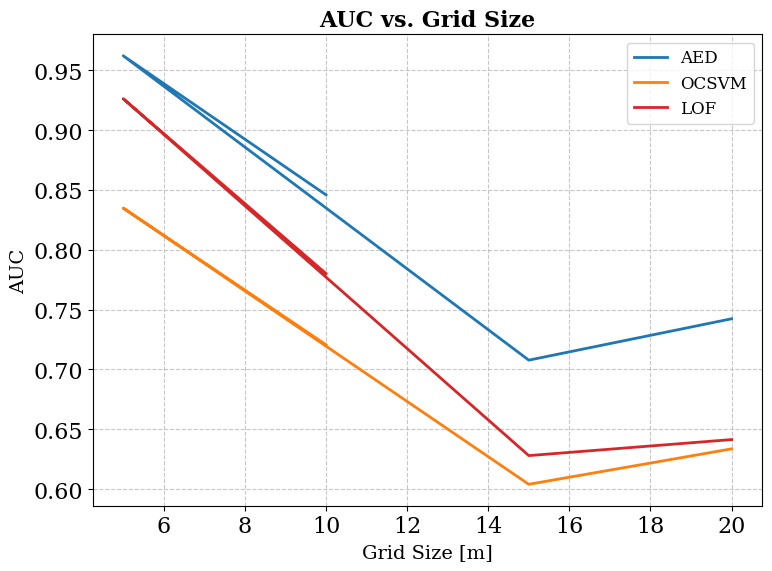

In [31]:
noise_std = 2.0  # Fixed noise standard deviation
plot_auc_vs_grid_size(noise_std, filenames_table, dataset_dir)

ROC Curves for two shadowing levels/grid sizes in one plot:

In [32]:
def load_results(grid_size, noise_std):
    """
    Load results from the dataset based on grid size and noise standard deviation.
    
    Parameters:
        grid_size (float): Grid size in meters.
        noise_std (float): Noise standard deviation in dB.
    
    Returns:
        dict: Results loaded from the dataset.
    """
    filename = description_file_utils.get_filename_by_params(
        filenames_table=filenames_table,
        noise_std=noise_std,
        grid_size=grid_size,
        tx_pos_inaccuracy_std=tx_pos_inaccuracy_std
    )
    dataset_nr = scanf('fspl_measurements%d', filename.split(os.sep)[-1])[0]
    with open(os.path.join(dataset_dir, f'fspl_results_{dataset_nr}_prob.pkl'), 'rb') as f_results:
        results = pickle.load(f_results)
    return results


def calculate_auc(y_test, y_hat, method):
    """
    Calculate the AUC score for a given method.
    
    Parameters:
        y_test (array-like): Ground truth labels.
        y_hat (array-like): Predicted scores.
        method (str): The name of the method.
    
    Returns:
        float: AUC score.
    """
    if method == 'one_class_svm':
        return roc_auc_score(y_test, 1 - y_hat)
    else:
        return roc_auc_score(y_test, y_hat)


def plot_roc_for_two_configs(grid_size, noise_std_by_config_idx, exclude_from_plot, linestyle_by_config_idx):
    """
    Plot ROC curves for two configurations.
    
    Parameters:
        grid_size (float): Grid size in meters.
        noise_std_by_config_idx (dict): Noise levels for configurations.
        exclude_from_plot (list): Methods to exclude from the plot.
        linestyle_by_config_idx (dict): Line styles for configurations.
    """
    legend_elements = []  # Store legend elements
    for config_idx, noise_std in noise_std_by_config_idx.items():
        # Load results
        results = load_results(grid_size, noise_std)

        # Plot ROC curves for each method
        for method in results:
            if method in exclude_from_plot:
                continue

            # Compute ROC curve
            y_test = results[method]['y_test']
            y_hat = results[method]['y_hat']
            fpr, tpr, _ = roc_curve(y_test, -y_hat if method == 'one_class_svm' else y_hat)

            # Plot the ROC curve
            plt.plot(fpr, tpr, color=method_colors[method],
                     linestyle=linestyle_by_config_idx[config_idx],
                     label=f'{method_labels[method]}' if config_idx == 0 else None)

            # Calculate AUC
            auc = calculate_auc(y_test, y_hat, method)

            # Add legend entry
            legend_label = f"{method_labels[method]} ($\\sigma$ = {noise_std} dB, AUC: {auc:.2f})"
            legend_elements.append(plt.Line2D([], [], color=method_colors[method], 
                                              linestyle=linestyle_by_config_idx[config_idx], 
                                              label=legend_label))

    # Add "No Skill" line
    plt.plot([0, 1], [0, 1], color='black', linestyle=':', linewidth=2, label='No skill')
    legend_elements.append(plt.Line2D([], [], color='black', linestyle=':', linewidth=2, label='No skill'))

    # Configure legend
    plt.legend(handles=legend_elements, fontsize=14, title="Method/Configuration", loc='lower right')

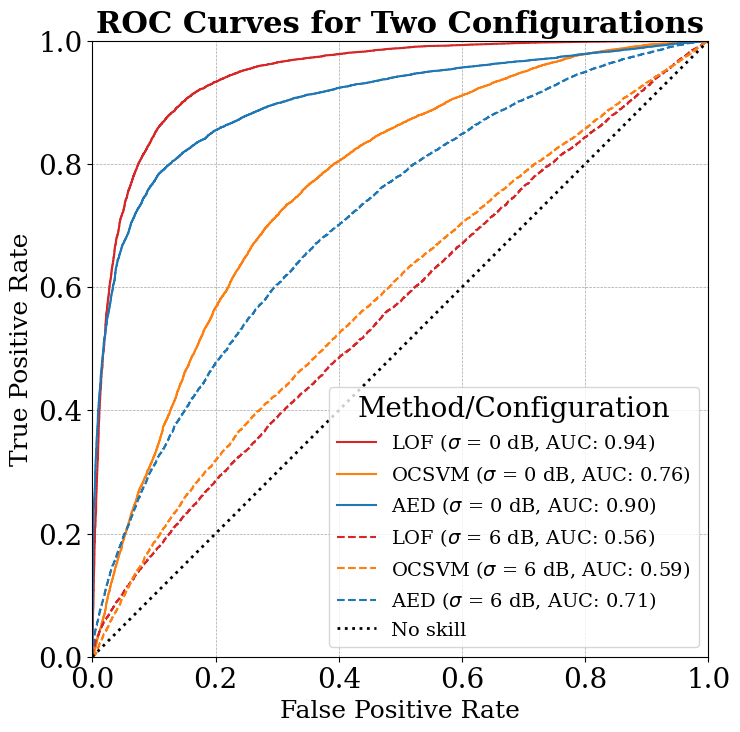

In [33]:
# Set parameters for the plot
param = 'noise_std'  # Choose 'noise_std' or 'grid_size'
exclude_from_plot = ['unsupervised_density', 'elliptic_envelope', 'dbscan']
linestyle_by_config_idx = {0: '-', 1: '--'}  # Line styles for two configurations
tx_pos_inaccuracy_std = 1.02  # Fixed parameter

# Plot configuration
plt.rcParams['font.size'] = 20  # Increase font size
plt.rcParams['figure.figsize'] = (8, 8)  # Larger figure size

# Noise levels for configurations
noise_std_by_config_idx = {0: 0, 1: 6}  # Two noise levels

# Call the plotting function
plot_roc_for_two_configs(10, noise_std_by_config_idx, exclude_from_plot, linestyle_by_config_idx)

# Configure labels, title, and grid
plt.title('ROC Curves for Two Configurations', fontsize=22, weight='bold')  # Larger title
plt.xlabel('False Positive Rate', fontsize=18)  # Larger x-label
plt.ylabel('True Positive Rate', fontsize=18)  # Larger y-label
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Adjust grid style

# Set aspect ratio
plt.gca().set_aspect('equal', 'box')
plt.xlim([0, 1])
plt.ylim([0, 1])

# Save and show the plot
figure_path = os.path.join(module_path, 'figures', 'fspl_anomaly_detection', 'roc_curves-noise_std.pdf')
plt.savefig(figure_path, bbox_inches='tight')
plt.show()

Our additional implementation starts here:

1. Exploratory Data Analysis using provided class methods
2. Dataset generation??

Section 1: EDA using class based methods provided in the github

In [34]:
#imports
import os
import pickle as pkl
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from scanf import scanf
import pandas as pd
from glob import glob
from tqdm import tqdm

# Import custom utility functions
from src.utils import description_file_utils
from src.utils.description_file_utils import get_param_by_filename_table, get_config_from_file
from src.utils import radiomap_utils as rmu
from src.utils import pl_utils as plu

In [35]:
#utility methods
def load_metadata_table(data_type):
    """
    Load metadata table based on the data type.

    Parameters:
        data_type (str): 'measurements', 'path_loss', or 'radiomap'.
    
    Returns:
        pd.DataFrame: Metadata table with filenames and parameters.
    """
    return get_param_by_filename_table('fspl', data_type)

def load_files_with_metadata(dataset_dir, metadata_table):
    """
    Load all files in the dataset directory and attach metadata.

    Parameters:
        dataset_dir (str): Path to the dataset directory.
        metadata_table (pd.DataFrame): Table with file metadata.

    Returns:
        list[dict]: List of dictionaries with 'file_name', 'object', and 'metadata'.
    """
    loaded_files = []
    for _, row in metadata_table.iterrows():
        file_path = os.path.join(dataset_dir, row['filename'] + '.pkl')
        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                obj = pkl.load(f)
            loaded_files.append({'file_name': row['filename'], 'object': obj, 'metadata': row.to_dict()})
        else:
            print(f"File not found: {file_path}")
    return loaded_files

def verify_radiomap_pairing(rm_orig, rm_dt, sample_idx=None):
    """
    Verify the pairing between an original radio map and its digital twin.

    Parameters:
        rm_orig (RadioMap): The original radio map.
        rm_dt (RadioMap): The digital twin radio map.
        sample_idx (int, optional): The index of the pair being compared.

    Returns:
        dict: Summary of differences and statistics, including:
            - Mean difference
            - Max difference
            - Transmitter alignment statistics
    """
    # Basic pairing information
    pairing_label = f"Sample {sample_idx}" if sample_idx is not None else "RadioMap Pair"
    print(f"\n=== Verifying {pairing_label} ===")
    print(f"Original Map: {len(rm_orig.transmitters)} Transmitters, {len(rm_orig.jammers)} Jammers")
    print(f"Digital Twin Map: {len(rm_dt.transmitters)} Transmitters, {len(rm_dt.jammers)} Jammers")

    # Transmitter alignment statistics
    tx_differences = []
    for tx_orig, tx_dt in zip(rm_orig.transmitters, rm_dt.transmitters):
        pos_diff = np.linalg.norm(np.array(tx_orig.tx_pos) - np.array(tx_dt.tx_pos))
        power_diff = abs(tx_orig.tx_power - tx_dt.tx_power)
        tx_differences.append((pos_diff, power_diff))

    # Compute mean and max differences for transmitter alignment
    pos_diffs = [diff[0] for diff in tx_differences]
    power_diffs = [diff[1] for diff in tx_differences]
    mean_pos_diff = np.mean(pos_diffs) if pos_diffs else 0
    max_pos_diff = max(pos_diffs) if pos_diffs else 0
    mean_power_diff = np.mean(power_diffs) if power_diffs else 0
    max_power_diff = max(power_diffs) if power_diffs else 0

    print("Transmitter Differences (Position [m], Power [dB]):")
    for diff in tx_differences:
        print(f"  - Position: {diff[0]:.2f} m, Power: {diff[1]:.2f} dB")
    print(f"  - Mean Position Difference: {mean_pos_diff:.2f} m")
    print(f"  - Max Position Difference: {max_pos_diff:.2f} m")
    print(f"  - Mean Power Difference: {mean_power_diff:.2f} dB")
    print(f"  - Max Power Difference: {max_power_diff:.2f} dB")

    # Compute radio map differences
    diff_map = rm_orig.radio_map - rm_dt.radio_map
    mean_diff = np.mean(diff_map)
    max_diff = np.max(np.abs(diff_map))

    print(f"Radio Map Mean Difference: {mean_diff:.2f} dB")
    print(f"Radio Map Max Difference: {max_diff:.2f} dB")

    # Return pairing summary (used in sampling and global analysis)
    return {
        "mean_diff": mean_diff,
        "max_diff": max_diff,
        "mean_pos_diff": mean_pos_diff,
        "max_pos_diff": max_pos_diff,
        "mean_power_diff": mean_power_diff,
        "max_power_diff": max_power_diff,
        "tx_differences": tx_differences,
    }

def resize_to_match(map1, map2):
    """
    Resize or truncate map2 to match the shape of map1.

    Parameters:
        map1 (np.ndarray): Reference map.
        map2 (np.ndarray): Map to resize or truncate.

    Returns:
        np.ndarray: Resized or truncated map.
    """
    target_shape = map1.shape
    return map2[:target_shape[0], :target_shape[1]]

def generate_digital_twin(rm_orig):
    """
    Generate a digital twin for a given original radio map.

    Parameters:
        rm_orig (RadioMap): The original radio map.

    Returns:
        RadioMap: The generated digital twin radio map.
    """
    # Use the shape and resolution from rm_orig
    rm_dt = rmu.RadioMap(rm_orig.radio_map.shape, rm_orig.resolution)
    
    pos_std = 1.0  # Standard deviation for transmitter position
    pos_cov = [[pos_std**2, 0], [0, pos_std**2]]

    for tx in rm_orig.transmitters:
        tx_pos_est = np.random.multivariate_normal(tx.tx_pos, pos_cov)
        pathlossmap = plu.generate_fspl_map(
            scene_size=rm_orig.radio_map.shape,  # Ensure same scene size
            resolution=rm_orig.resolution,       # Match resolution
            tx_pos=tx_pos_est,
            f_c=2.4e9                            # Frequency in Hz (modify as needed)
        )
        rm_dt.add_transmitter(tx.tx_type, tx_pos_est, tx.tx_power, pathlossmap)

    # Verify shape matches
    if rm_orig.radio_map.shape != rm_dt.radio_map.shape:
        print("Shape mismatch detected. Adjusting rm_dt to match rm_orig.")
        rm_dt.radio_map = resize_to_match(rm_orig.radio_map, rm_dt.radio_map)

    return rm_dt

def verify_all_pairings(radiomaps, metadata):
    """
    Verify all radio map pairings within a dataset.

    Parameters:
        radiomaps (list): List of original radio maps.
        metadata (dict): Metadata associated with the file.

    Returns:
        list: Summary statistics for each pair.
    """
    print(f"\nVerifying Pairings in Dataset: {metadata['filename']}")
    results = []
    for idx, rm_orig in enumerate(radiomaps):
        # Generate the digital twin for the given `rm_orig` using the same method as in measurement generation
        rm_dt = generate_digital_twin(rm_orig)
        summary = verify_radiomap_pairing(rm_orig, rm_dt, idx)
        results.append(summary)
    return results

# Filtering method (applies only to measurement files)
def filter_measurements(metadata_table, filters):
    """
    Filters the metadata table for measurement files based on given parameters.

    Parameters:
        metadata_table (pd.DataFrame): Table containing metadata for measurement files.
        filters (dict): Dictionary of filters to apply, e.g., {"noise_std": 5, "grid_size": 10}.
    
    Returns:
        pd.DataFrame: Filtered metadata table.
    """
    filtered_table = metadata_table.copy()
    for key, value in filters.items():
        if key in filtered_table.columns:
            filtered_table = filtered_table[filtered_table[key] == value]
    return filtered_table

In [36]:
#methods to analyze class objects at a general level

def analyze_measurement_collection(measurements, metadata):
    """
    Analyze a MeasurementCollection object.

    Parameters:
        measurements (MeasurementCollection): MeasurementCollection object to analyze.
        metadata (dict): Metadata associated with the file.
    """
    file_name = os.path.basename(metadata['filename'])  # Truncate filename
    grid_size = metadata.get('grid_size', 'Unknown')
    noise_std = metadata.get('noise_std', 'Unknown')
    num_points = len(measurements.meas_x)
    num_differences = len(measurements.measurements_diff_list)
    num_transmitters = sum(len(txs) for txs in measurements.transmitters_list)
    num_jammers = sum(len(js) for js in measurements.jammers_list)

    # Basic Metadata and Summary
    print(f"\nAnalyzing MeasurementCollection: {file_name}")
    print(f"  - Measurement Method: {measurements.method}")
    print(f"  - Grid Size: {grid_size} m")
    print(f"  - Noise Std Dev: {noise_std} dB")
    print(f"  - Number of Measurement Points: {num_points}")
    print(f"  - Number of Measurement Differences: {num_differences}")
    print(f"  - Total Transmitters in Measurements: {num_transmitters}")
    print(f"  - Total Jammers in Measurements: {num_jammers}")

    # Spatial Extent
    x_range = (min(measurements.meas_x), max(measurements.meas_x))
    y_range = (min(measurements.meas_y), max(measurements.meas_y))
    print(f"  - X Range: {x_range[0]} to {x_range[1]} m")
    print(f"  - Y Range: {y_range[0]} to {y_range[1]} m")

    # Summarize Measurement Differences
    mean_differences = [np.mean(diff) for diff in measurements.measurements_diff_list]
    std_differences = [np.std(diff) for diff in measurements.measurements_diff_list]

    print("\nSummary Statistics for Measurement Differences:")
    print(f"  - Mean of Means: {np.mean(mean_differences):.2f} dB")
    print(f"  - Std Dev of Means: {np.std(mean_differences):.2f} dB")
    print(f"  - Min Mean Difference: {np.min(mean_differences):.2f} dB")
    print(f"  - Max Mean Difference: {np.max(mean_differences):.2f} dB")

    # Summarize Transmitters and Jammers
    tx_counts = [len(txs) for txs in measurements.transmitters_list]
    jammer_counts = [len(js) for js in measurements.jammers_list]
    print("\nSummary of Transmitters and Jammers:")
    print(f"  - Mean Transmitters per Measurement: {np.mean(tx_counts):.2f}")
    print(f"  - Mean Jammers per Measurement: {np.mean(jammer_counts):.2f}")

    # KDE Plot for Measurement Differences
    plt.figure(figsize=(10, 6))
    sns.kdeplot(mean_differences, label="Mean Measurement Difference", fill=True, color="blue", alpha=0.5)
    sns.kdeplot(std_differences, label="Std Dev of Measurement Difference", fill=True, color="orange", alpha=0.5)
    plt.xlabel("Measurement Difference [dB]")
    plt.title(f"Measurement Differences ({file_name})")
    plt.legend(loc="upper right")
    plt.grid()
    plt.tight_layout()
    plt.show()

def analyze_radio_map_collection(radio_maps, metadata):
    """
    Analyze a collection of RadioMap objects.

    Parameters:
        radio_maps (list): List of RadioMap objects.
        metadata (dict): Metadata associated with the file.
    """
    file_name = os.path.basename(metadata['filename'])
    print(f"\n=== Analyzing RadioMap Collection: {file_name} ===")
    print(f"Number of RadioMaps: {len(radio_maps)}")
    print(f"Noise Std Dev: {metadata.get('noise_std', 'Unknown')} dB")
    print(f"Resolution: {radio_maps[0].resolution if radio_maps else 'Unknown'}")

    # Summarize the first few maps for context
    transmitter_counts = []
    jammer_counts = []
    mean_powers = []

    for idx, rm in enumerate(radio_maps):
        num_transmitters = len(rm.transmitters)
        num_jammers = len(rm.jammers)
        mean_power = np.mean(rm.radio_map)

        transmitter_counts.append(num_transmitters)
        jammer_counts.append(num_jammers)
        mean_powers.append(mean_power)

    # Summary statistics
    print("\nSummary Statistics Across All RadioMaps:")
    print(f"  - Average Number of Transmitters: {np.mean(transmitter_counts):.2f}")
    print(f"  - Average Number of Jammers: {np.mean(jammer_counts):.2f}")
    print(f"  - Overall Mean Power: {np.mean(mean_powers):.2f} dBm")

    # KDE plot of mean power
    sns.kdeplot(mean_powers, label="Mean Power Distribution")
    plt.xlabel("Mean Power [dBm]")
    plt.ylabel("Density")
    plt.title(f"Mean Power Distribution ({file_name})")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_path_loss_collection(path_loss_map_collection, metadata, file_name):
    """
    Analyze a PathLossMapCollection object.

    Parameters:
        path_loss_map_collection (PathLossMapCollection): Object to analyze.
        metadata (dict): Metadata associated with the file.
        file_name (str): Name of the file being analyzed.
    """
    file_name = os.path.basename(file_name)  # Truncate filename
    print(f"\nAnalyzing PathLossMapCollection: {file_name}")
    print(f"Number of PathLossMaps: {len(path_loss_map_collection.pathlossmaps)}")
    for idx, plm in enumerate(path_loss_map_collection.pathlossmaps[:5]):  # Summarize first few maps
        print(f"PathLossMap {idx + 1}: Transmitter Position {plm.tx_pos}, Max Loss: {np.max(plm.pathloss):.2f} dB")

In [37]:
# sample and analyze single data points

def sample_and_visualize_measurement(measurements, metadata):
    """
    Sample and visualize a random measurement from a MeasurementCollection.

    Parameters:
        measurements (MeasurementCollection): MeasurementCollection object to sample.
        metadata (dict): Metadata associated with the file.
    """
    # Randomly sample an index
    sample_idx = np.random.randint(0, len(measurements.measurements_diff_list))
    diff_sample = measurements.measurements_diff_list[sample_idx]
    tx_sample = measurements.transmitters_list[sample_idx]
    jammer_sample = measurements.jammers_list[sample_idx]

    # Metadata and context
    file_name = os.path.basename(metadata['filename'])
    grid_size = metadata.get('grid_size', 'Unknown')
    noise_std = metadata.get('noise_std', 'Unknown')
    meas_x = measurements.meas_x
    meas_y = measurements.meas_y

    # Statistics
    mean_diff = np.mean(diff_sample)
    std_diff = np.std(diff_sample)
    min_diff = np.min(diff_sample)
    max_diff = np.max(diff_sample)

    print(f"\nVisualizing Measurement Sample {sample_idx} ({file_name}):")
    print(f"  - Grid Size: {grid_size} m")
    print(f"  - Noise Std Dev: {noise_std} dB")
    print(f"  - Mean Difference: {mean_diff:.2f} dB")
    print(f"  - Std Dev of Difference: {std_diff:.2f} dB")
    print(f"  - Min Difference: {min_diff:.2f} dB")
    print(f"  - Max Difference: {max_diff:.2f} dB")
    print(f"  - Number of Transmitters: {len(tx_sample)}")
    print(f"  - Number of Jammers: {len(jammer_sample)}")

    # Plot the measurement differences
    plt.figure(figsize=(8, 6))
    plt.plot(diff_sample, label="Measurement Difference")
    plt.axhline(mean_diff, color="red", linestyle="--", label=f"Mean = {mean_diff:.2f} dB")
    plt.axhline(min_diff, color="green", linestyle=":", label=f"Min = {min_diff:.2f} dB")
    plt.axhline(max_diff, color="orange", linestyle=":", label=f"Max = {max_diff:.2f} dB")
    plt.title(f"Measurement Difference Sample {sample_idx} ({file_name})")
    plt.xlabel("Measurement Point Index")
    plt.ylabel("Difference [dB]")
    plt.grid()
    
    # Adjust legend to be outside the plot area
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.tight_layout()
    plt.show()

    # Transmitter and jammer details
    if tx_sample:
        print("\nTransmitters in Sample:")
        for tx in tx_sample:
            print(f"  - Type: {tx.tx_type}, Position: {tx.tx_pos}, Power: {tx.tx_power} dBm")

    if jammer_sample:
        print("\nJammers in Sample:")
        for jammer in jammer_sample:
            print(f"  - Type: {jammer.tx_type}, Position: {jammer.tx_pos}, Power: {jammer.tx_power} dBm")

def sample_and_compare_radio_maps(radio_maps, metadata, num_samples=3):
    """
    Sample and compare a few original and digital twin RadioMaps.

    Parameters:
        radio_maps (list): List of RadioMap objects.
        metadata (dict): Metadata associated with the file.
        num_samples (int): Number of samples to visualize and compare.
    """
    file_name = os.path.basename(metadata['filename'])
    print(f"\n=== Sampling and Comparing RadioMaps ({file_name}) ===")

    sampled_indices = random.sample(range(len(radio_maps)), num_samples)
    for sample_idx in sampled_indices:
        rm_orig = radio_maps[sample_idx]
        rm_dt = generate_digital_twin(rm_orig)

        print(f"\n--- Sample {sample_idx}: Original vs. Digital Twin ---")
        print(f"  - Number of Transmitters: {len(rm_orig.transmitters)}")
        print(f"  - Number of Jammers: {len(rm_orig.jammers)}")

        # Display Original Radio Map
        print("\nOriginal Radio Map:")
        rm_orig.show_radio_map(plot_transmitters=True, vmin=-100, vmax=0)

        # Display Digital Twin Radio Map
        print("\nDigital Twin Radio Map:")
        rm_dt.show_radio_map(plot_transmitters=True, vmin=-100, vmax=0)

        # Pairwise comparison stats (reusing verify_radiomap_pairing)
        print("\nPairwise Comparison Statistics:")
        pairing_summary = verify_radiomap_pairing(rm_orig, rm_dt, sample_idx)

        # Visualize Difference Map (moved from verify_radiomap_pairing)
        diff_map = rm_orig.radio_map - rm_dt.radio_map
        sns.heatmap(diff_map.T, cmap="coolwarm", center=0, cbar_kws={"label": "Difference [dB]"})
        plt.title(f"RadioMap Difference (Sample {sample_idx})")
        plt.xlabel("X Index")
        plt.ylabel("Y Index")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print(f"  - Mean Difference: {pairing_summary['mean_diff']:.2f} dB")
        print(f"  - Max Difference: {pairing_summary['max_diff']:.2f} dB")

def sample_and_visualize_path_loss_map(path_loss_map_collection, metadata):
    """
    Sample and visualize a random PathLossMap from a collection.

    Parameters:
        path_loss_map_collection (PathLossMapCollection): Object containing PathLossMap objects.
        metadata (dict): Metadata associated with the file.
    """
    # Randomly sample a PathLossMap
    sample_idx = np.random.randint(0, len(path_loss_map_collection.pathlossmaps))
    path_loss_map = path_loss_map_collection.pathlossmaps[sample_idx]
    file_name = os.path.basename(metadata['filename'])
    tx_pos = path_loss_map.tx_pos
    pathloss = path_loss_map.pathloss

    # Summary statistics
    max_loss = np.max(pathloss)
    min_loss = np.min(pathloss)
    mean_loss = np.mean(pathloss)

    print(f"\nVisualizing PathLossMap Sample {sample_idx} ({file_name}):")
    print(f"  - Transmitter Position: {tx_pos}")
    print(f"  - Max Path Loss: {max_loss:.2f} dB")
    print(f"  - Min Path Loss: {min_loss:.2f} dB")
    print(f"  - Mean Path Loss: {mean_loss:.2f} dB")
    print(f"  - Map Shape: {pathloss.shape}")

    # Use the show_pathloss_map method for visualization
    print("\nDisplaying PathLossMap heatmap...")
    path_loss_map.show_pathloss_map(show_tx_pos=True)


Loading measurements files...
Loading radiomap files...
Loading path_loss files...

=== Global Analysis for Measurements: fspl_measurements10 ===

Analyzing MeasurementCollection: fspl_measurements10
  - Measurement Method: grid
  - Grid Size: 5.0 m
  - Noise Std Dev: 2.0 dB
  - Number of Measurement Points: 81
  - Number of Measurement Differences: 30000
  - Total Transmitters in Measurements: 300000
  - Total Jammers in Measurements: 14945
  - X Range: 0 to 40 m
  - Y Range: 0 to 40 m

Summary Statistics for Measurement Differences:
  - Mean of Means: 0.55 dB
  - Std Dev of Means: 0.34 dB
  - Min Mean Difference: -0.62 dB
  - Max Mean Difference: 1.87 dB

Summary of Transmitters and Jammers:
  - Mean Transmitters per Measurement: 10.00
  - Mean Jammers per Measurement: 0.50


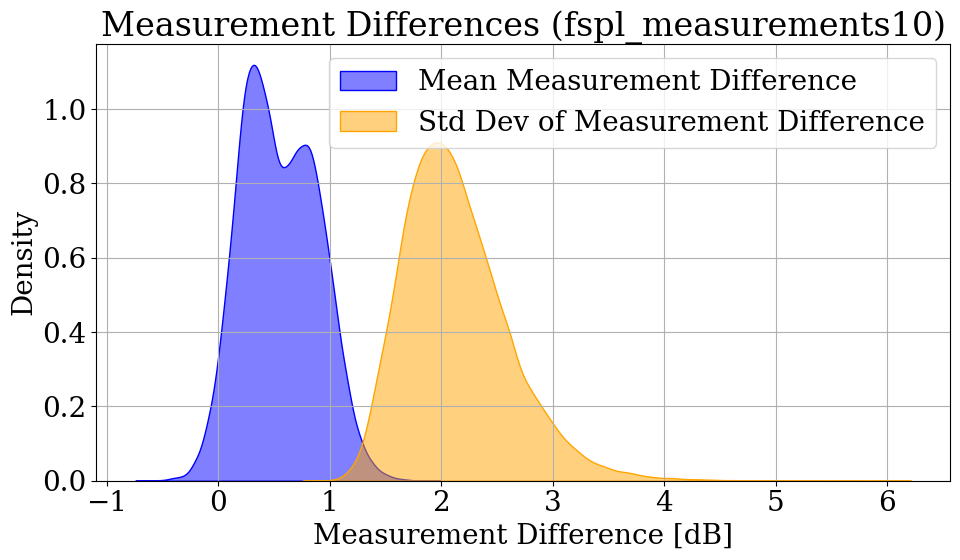


=== Instance-Based Insights for Measurements: fspl_measurements10 ===

Visualizing Measurement Sample 29123 (fspl_measurements10):
  - Grid Size: 5.0 m
  - Noise Std Dev: 2.0 dB
  - Mean Difference: 0.74 dB
  - Std Dev of Difference: 1.86 dB
  - Min Difference: -4.67 dB
  - Max Difference: 6.49 dB
  - Number of Transmitters: 10
  - Number of Jammers: 1


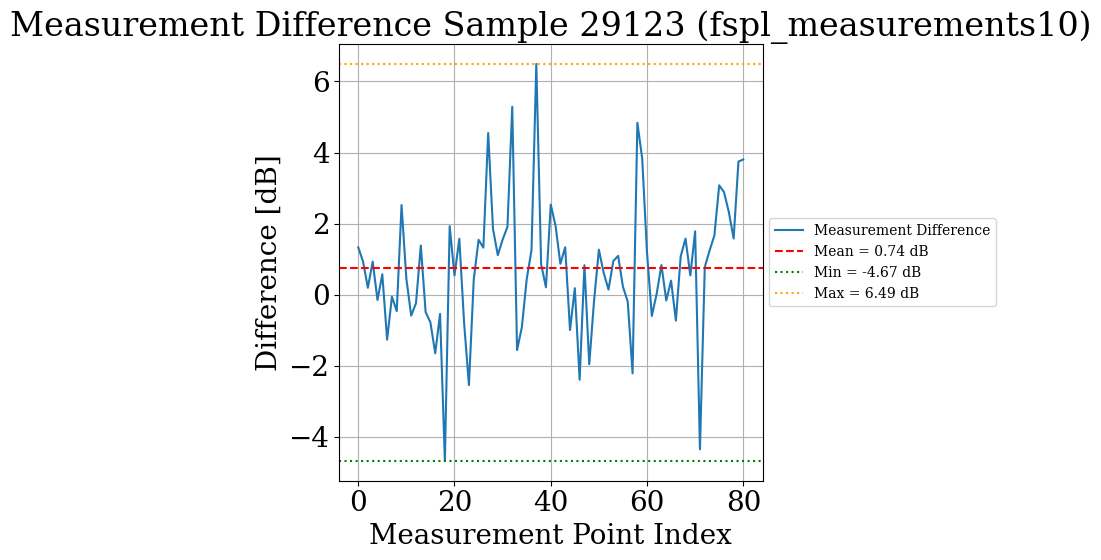


Transmitters in Sample:
  - Type: tx, Position: [13, 0], Power: 20 dBm
  - Type: tx, Position: [40, 39], Power: 20 dBm
  - Type: tx, Position: [28, 16], Power: 20 dBm
  - Type: tx, Position: [7, 7], Power: 20 dBm
  - Type: tx, Position: [29, 18], Power: 20 dBm
  - Type: tx, Position: [20, 5], Power: 20 dBm
  - Type: tx, Position: [13, 24], Power: 20 dBm
  - Type: tx, Position: [7, 39], Power: 20 dBm
  - Type: tx, Position: [20, 34], Power: 20 dBm
  - Type: tx, Position: [25, 15], Power: 20 dBm

Jammers in Sample:
  - Type: jammer, Position: [28, 18], Power: 20.0 dBm

=== Global Analysis for RadioMaps: fspl_RMdataset0 ===

=== Analyzing RadioMap Collection: fspl_RMdataset0 ===
Number of RadioMaps: 30000
Noise Std Dev: 0.0 dB
Resolution: 1

Summary Statistics Across All RadioMaps:
  - Average Number of Transmitters: 10.00
  - Average Number of Jammers: 0.50
  - Overall Mean Power: -35.30 dBm


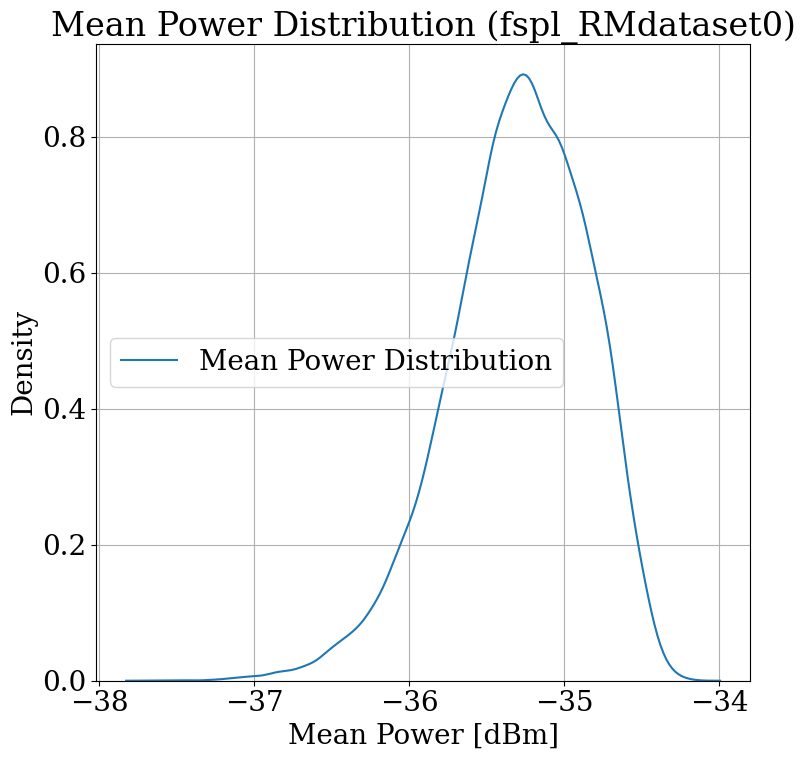


=== Instance-Based Insights for RadioMaps: fspl_RMdataset0 ===

=== Sampling and Comparing RadioMaps (fspl_RMdataset0) ===

--- Sample 29851: Original vs. Digital Twin ---
  - Number of Transmitters: 10
  - Number of Jammers: 1

Original Radio Map:


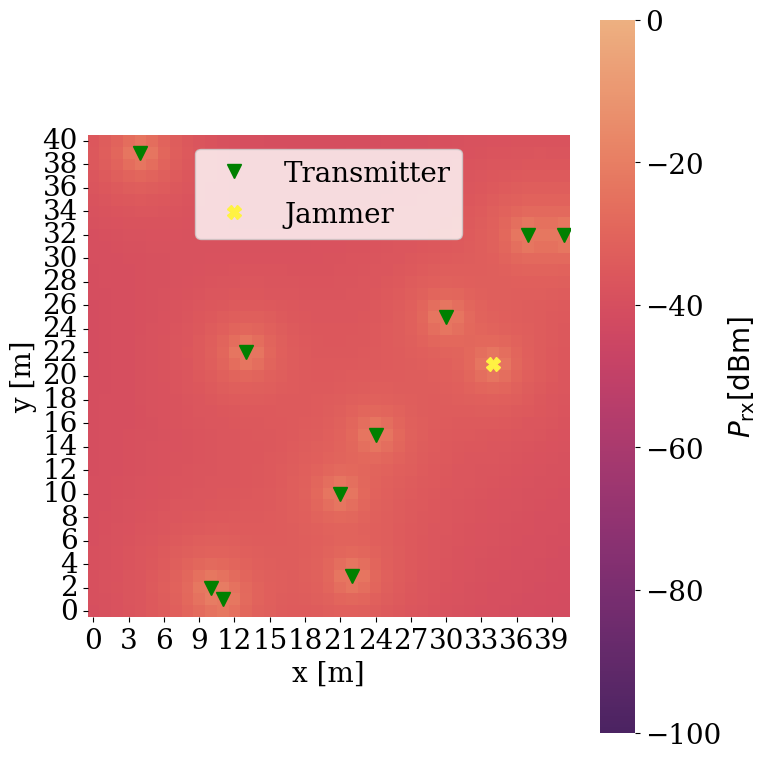


Digital Twin Radio Map:


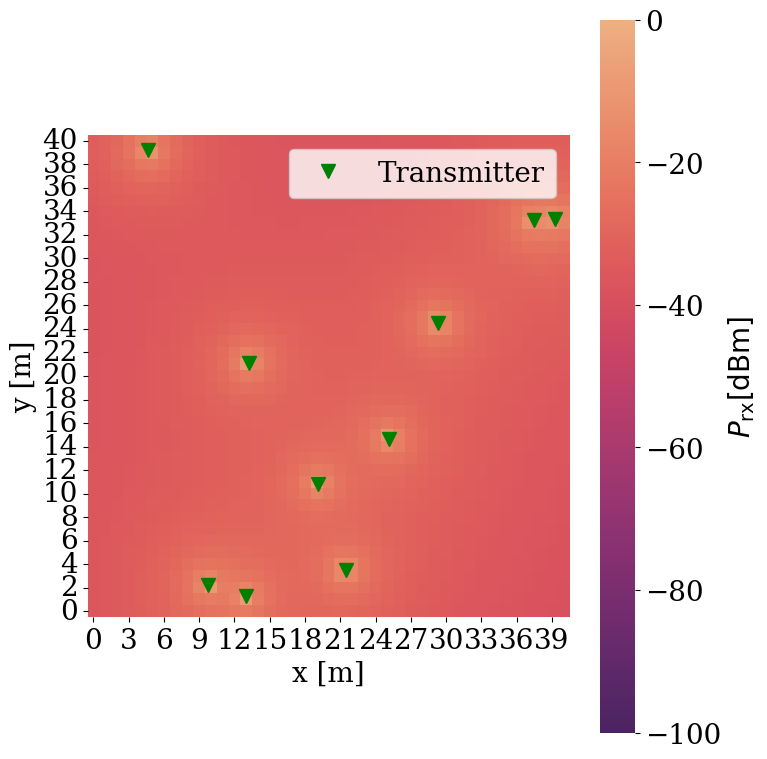


Pairwise Comparison Statistics:

=== Verifying Sample 29851 ===
Original Map: 10 Transmitters, 1 Jammers
Digital Twin Map: 10 Transmitters, 0 Jammers
Transmitter Differences (Position [m], Power [dB]):
  - Position: 0.31 m, Power: 0.00 dB
  - Position: 0.70 m, Power: 0.00 dB
  - Position: 1.54 m, Power: 0.00 dB
  - Position: 1.96 m, Power: 0.00 dB
  - Position: 0.73 m, Power: 0.00 dB
  - Position: 2.03 m, Power: 0.00 dB
  - Position: 0.81 m, Power: 0.00 dB
  - Position: 1.32 m, Power: 0.00 dB
  - Position: 1.18 m, Power: 0.00 dB
  - Position: 0.89 m, Power: 0.00 dB
  - Mean Position Difference: 1.15 m
  - Max Position Difference: 2.03 m
  - Mean Power Difference: 0.00 dB
  - Max Power Difference: 0.00 dB
Radio Map Mean Difference: -3.33 dB
Radio Map Max Difference: 22.33 dB


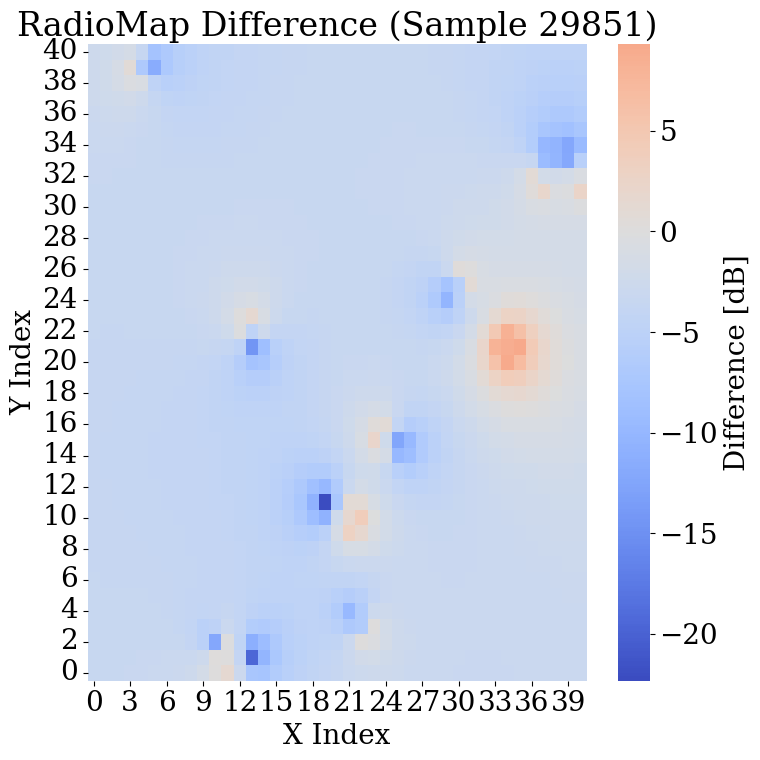

  - Mean Difference: -3.33 dB
  - Max Difference: 22.33 dB

=== Global Analysis for RadioMaps: fspl_RMdataset1 ===

=== Analyzing RadioMap Collection: fspl_RMdataset1 ===
Number of RadioMaps: 30000
Noise Std Dev: 2.0 dB
Resolution: 1

Summary Statistics Across All RadioMaps:
  - Average Number of Transmitters: 10.00
  - Average Number of Jammers: 0.50
  - Overall Mean Power: -34.97 dBm


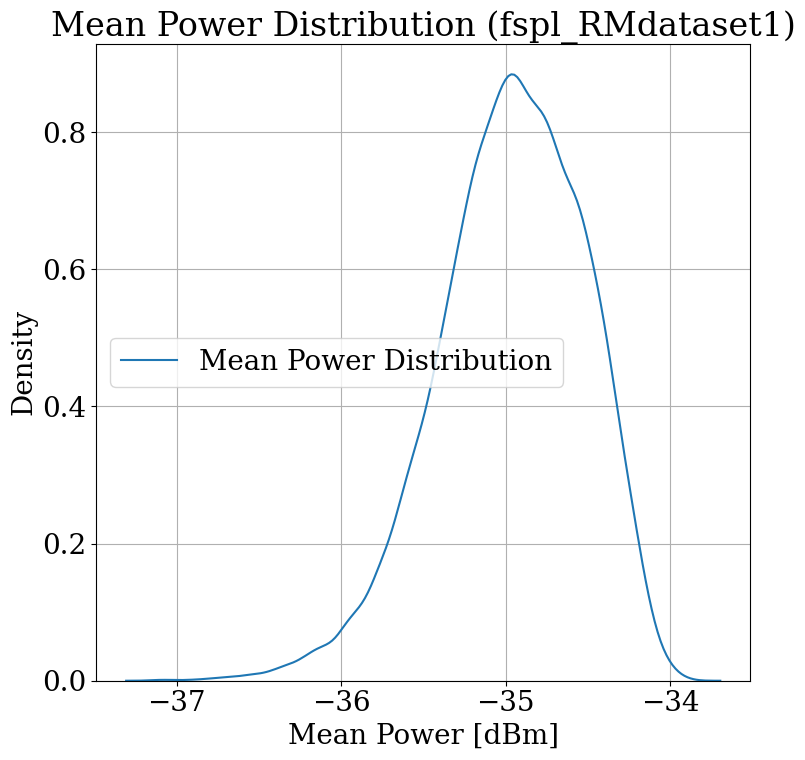


=== Instance-Based Insights for RadioMaps: fspl_RMdataset1 ===

=== Sampling and Comparing RadioMaps (fspl_RMdataset1) ===

--- Sample 21166: Original vs. Digital Twin ---
  - Number of Transmitters: 10
  - Number of Jammers: 0

Original Radio Map:


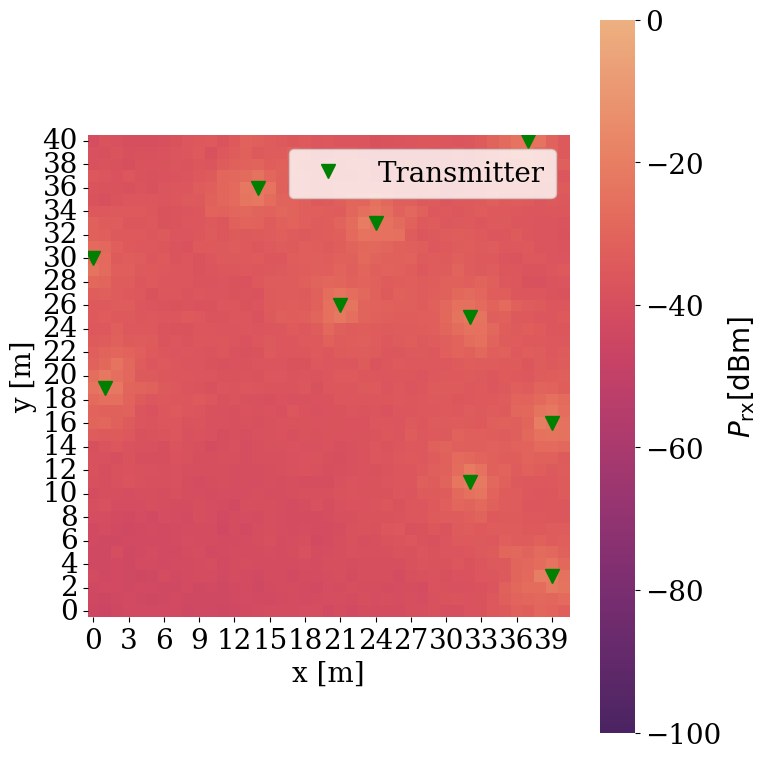


Digital Twin Radio Map:


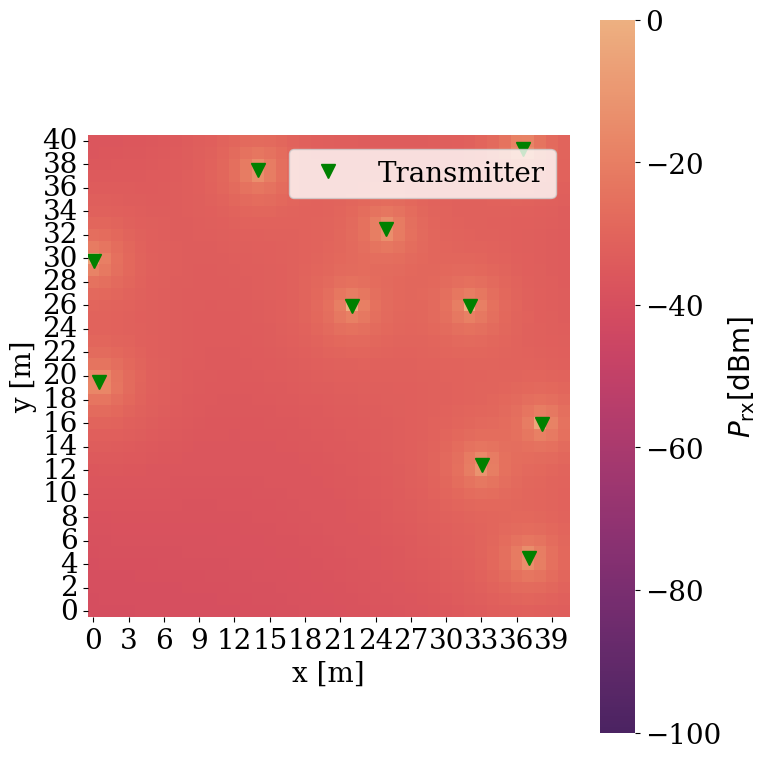


Pairwise Comparison Statistics:

=== Verifying Sample 21166 ===
Original Map: 10 Transmitters, 0 Jammers
Digital Twin Map: 10 Transmitters, 0 Jammers
Transmitter Differences (Position [m], Power [dB]):
  - Position: 1.73 m, Power: 0.00 dB
  - Position: 1.02 m, Power: 0.00 dB
  - Position: 1.05 m, Power: 0.00 dB
  - Position: 1.49 m, Power: 0.00 dB
  - Position: 2.42 m, Power: 0.00 dB
  - Position: 0.93 m, Power: 0.00 dB
  - Position: 0.69 m, Power: 0.00 dB
  - Position: 0.85 m, Power: 0.00 dB
  - Position: 0.81 m, Power: 0.00 dB
  - Position: 0.18 m, Power: 0.00 dB
  - Mean Position Difference: 1.12 m
  - Max Position Difference: 2.42 m
  - Mean Power Difference: 0.00 dB
  - Max Power Difference: 0.00 dB
Radio Map Mean Difference: -3.51 dB
Radio Map Max Difference: 28.60 dB


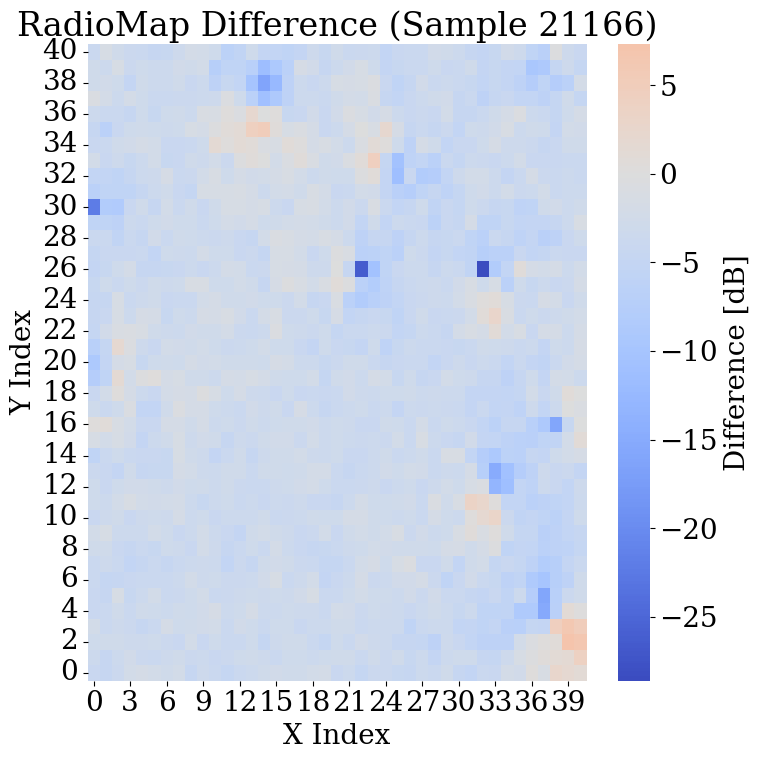

  - Mean Difference: -3.51 dB
  - Max Difference: 28.60 dB

=== Global Analysis for RadioMaps: fspl_RMdataset2 ===

=== Analyzing RadioMap Collection: fspl_RMdataset2 ===
Number of RadioMaps: 30000
Noise Std Dev: 4.0 dB
Resolution: 1

Summary Statistics Across All RadioMaps:
  - Average Number of Transmitters: 10.00
  - Average Number of Jammers: 0.50
  - Overall Mean Power: -34.07 dBm


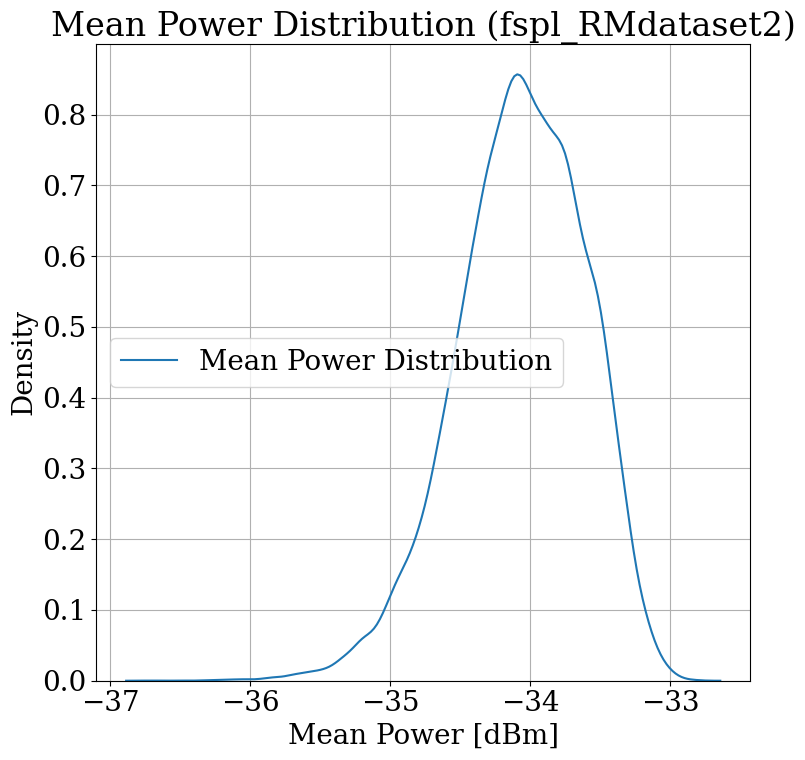


=== Instance-Based Insights for RadioMaps: fspl_RMdataset2 ===

=== Sampling and Comparing RadioMaps (fspl_RMdataset2) ===

--- Sample 9288: Original vs. Digital Twin ---
  - Number of Transmitters: 10
  - Number of Jammers: 1

Original Radio Map:


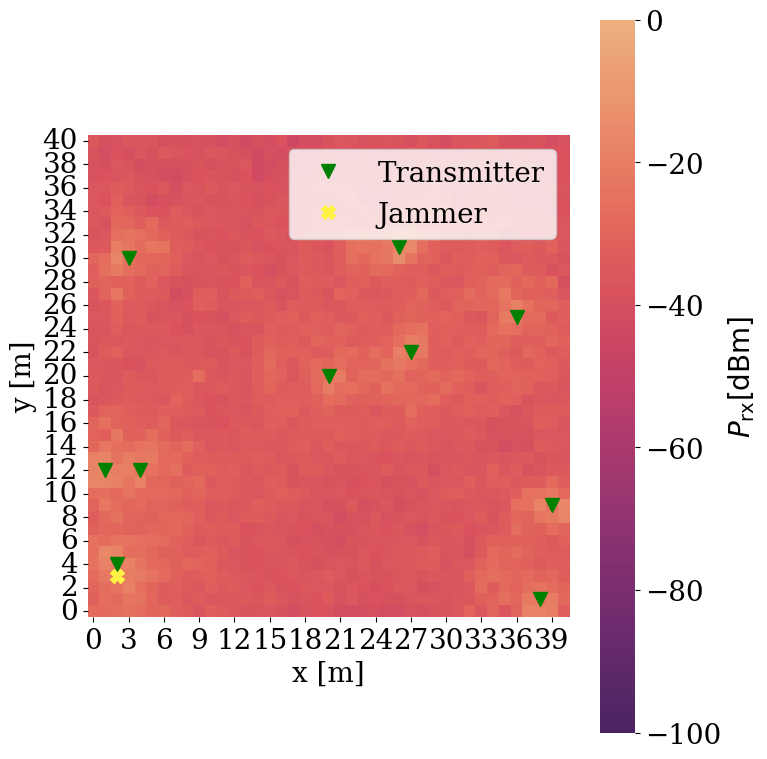


Digital Twin Radio Map:


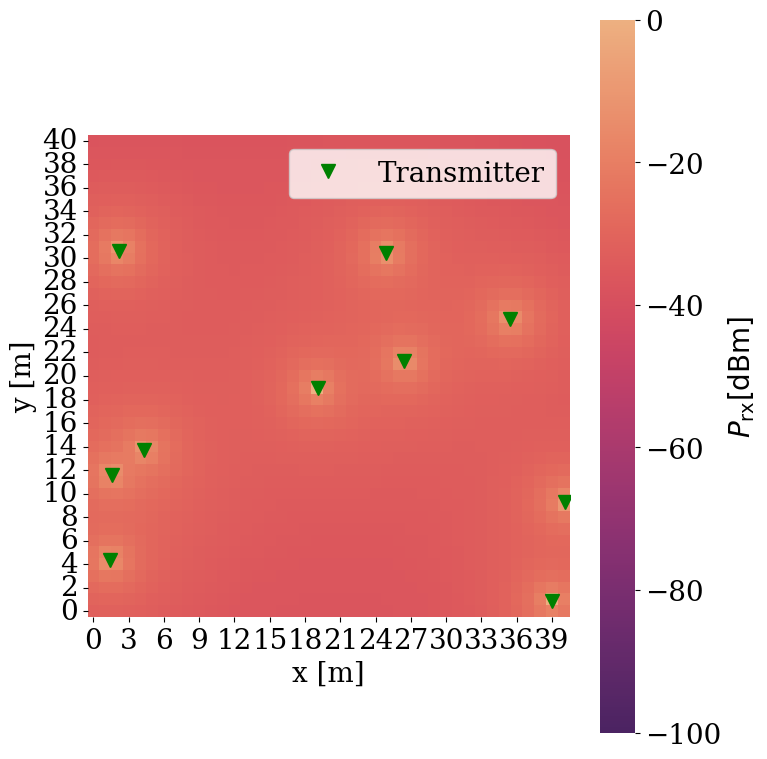


Pairwise Comparison Statistics:

=== Verifying Sample 9288 ===
Original Map: 10 Transmitters, 1 Jammers
Digital Twin Map: 10 Transmitters, 0 Jammers
Transmitter Differences (Position [m], Power [dB]):
  - Position: 0.91 m, Power: 0.00 dB
  - Position: 0.67 m, Power: 0.00 dB
  - Position: 1.07 m, Power: 0.00 dB
  - Position: 1.41 m, Power: 0.00 dB
  - Position: 0.71 m, Power: 0.00 dB
  - Position: 1.17 m, Power: 0.00 dB
  - Position: 1.73 m, Power: 0.00 dB
  - Position: 1.22 m, Power: 0.00 dB
  - Position: 1.02 m, Power: 0.00 dB
  - Position: 0.57 m, Power: 0.00 dB
  - Mean Position Difference: 1.05 m
  - Max Position Difference: 1.73 m
  - Mean Power Difference: 0.00 dB
  - Max Power Difference: 0.00 dB
Radio Map Mean Difference: -2.00 dB
Radio Map Max Difference: 29.88 dB


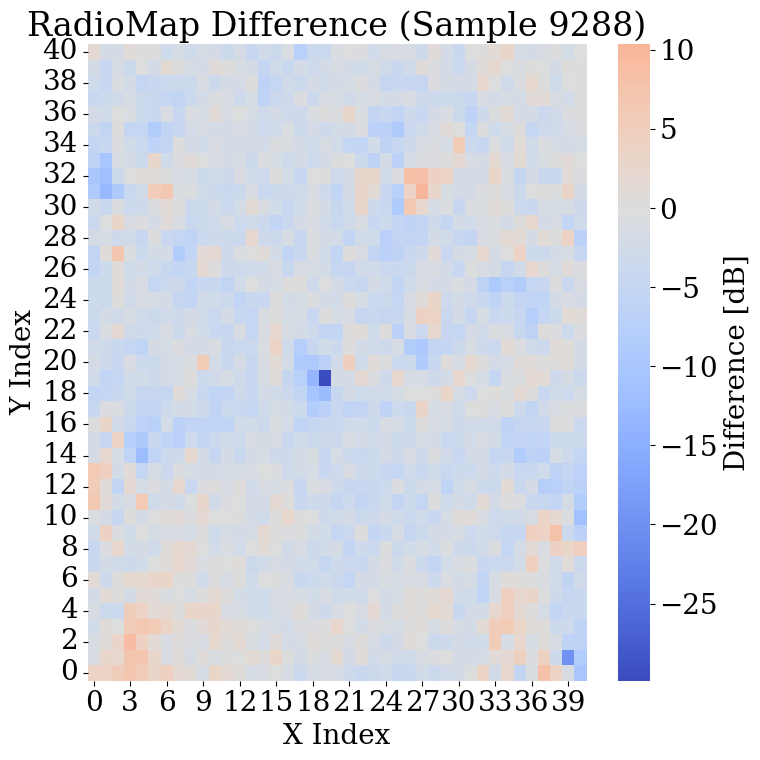

  - Mean Difference: -2.00 dB
  - Max Difference: 29.88 dB

=== Global Analysis for RadioMaps: fspl_RMdataset3 ===

=== Analyzing RadioMap Collection: fspl_RMdataset3 ===
Number of RadioMaps: 30000
Noise Std Dev: 6.0 dB
Resolution: 1

Summary Statistics Across All RadioMaps:
  - Average Number of Transmitters: 10.00
  - Average Number of Jammers: 0.50
  - Overall Mean Power: -32.77 dBm


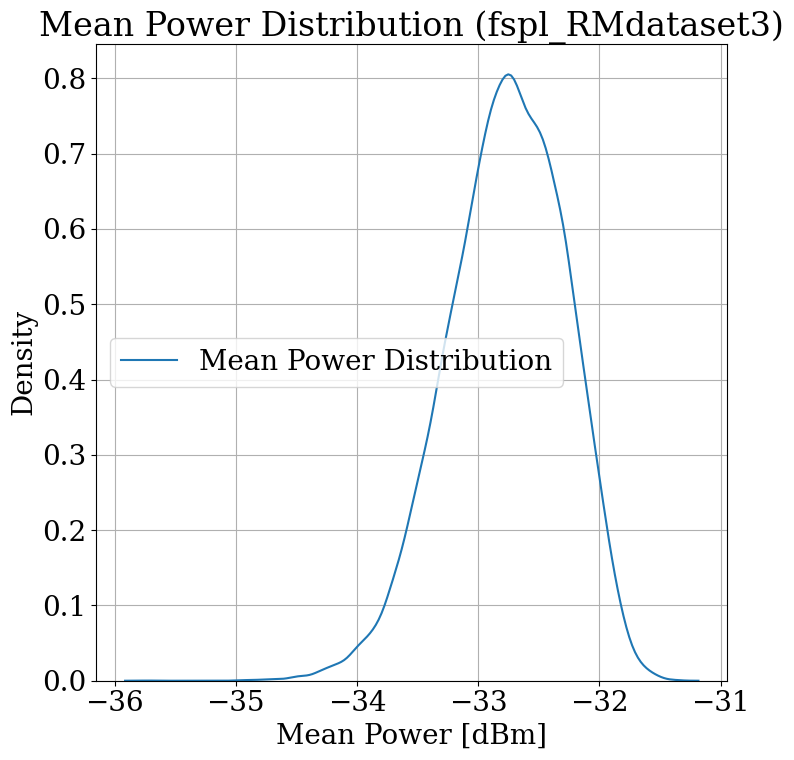


=== Instance-Based Insights for RadioMaps: fspl_RMdataset3 ===

=== Sampling and Comparing RadioMaps (fspl_RMdataset3) ===

--- Sample 27408: Original vs. Digital Twin ---
  - Number of Transmitters: 10
  - Number of Jammers: 1

Original Radio Map:


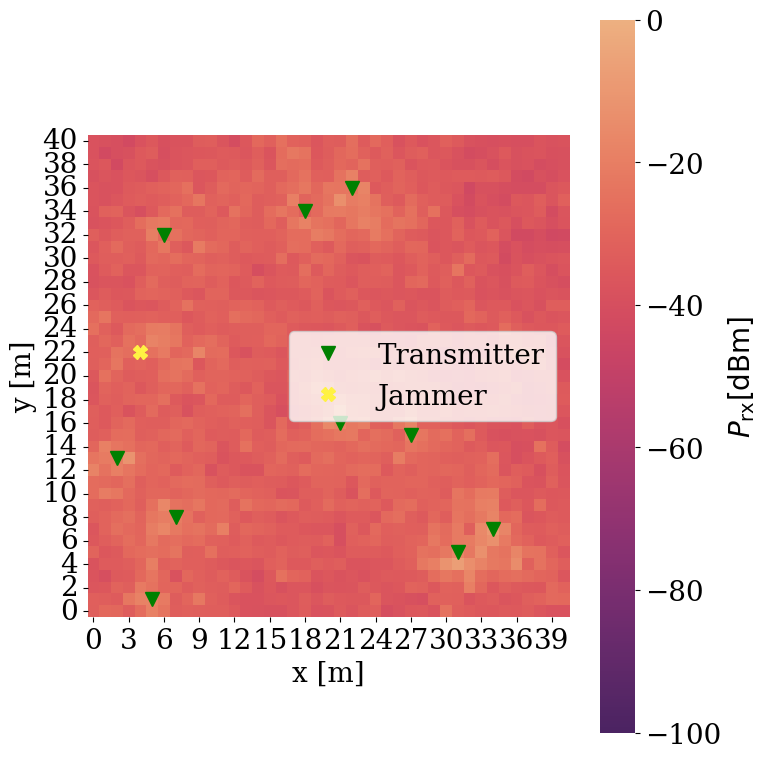


Digital Twin Radio Map:


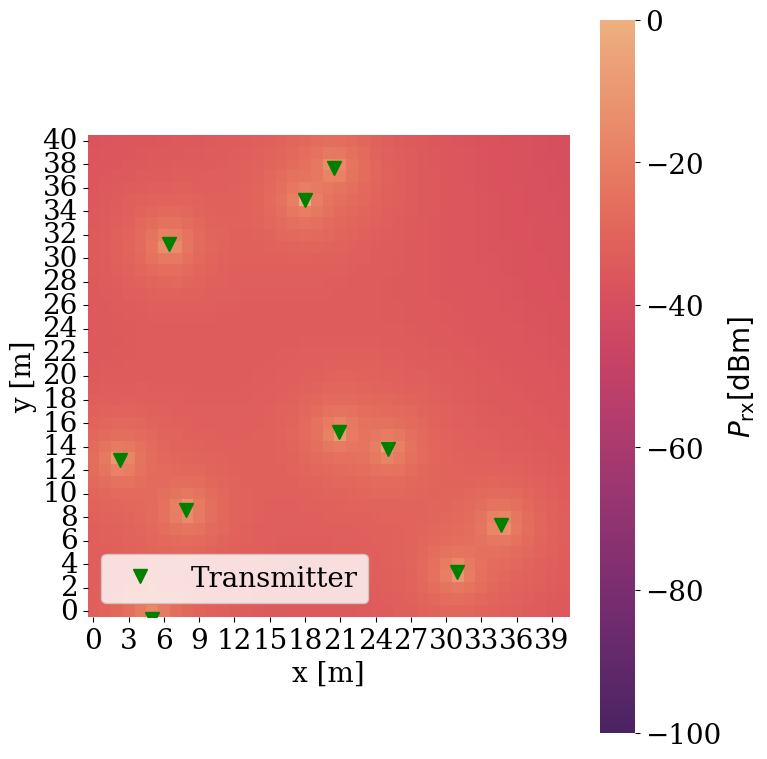


Pairwise Comparison Statistics:

=== Verifying Sample 27408 ===
Original Map: 10 Transmitters, 1 Jammers
Digital Twin Map: 10 Transmitters, 0 Jammers
Transmitter Differences (Position [m], Power [dB]):
  - Position: 2.32 m, Power: 0.00 dB
  - Position: 0.98 m, Power: 0.00 dB
  - Position: 2.26 m, Power: 0.00 dB
  - Position: 1.66 m, Power: 0.00 dB
  - Position: 0.81 m, Power: 0.00 dB
  - Position: 0.72 m, Power: 0.00 dB
  - Position: 1.09 m, Power: 0.00 dB
  - Position: 1.69 m, Power: 0.00 dB
  - Position: 0.93 m, Power: 0.00 dB
  - Position: 0.33 m, Power: 0.00 dB
  - Mean Position Difference: 1.28 m
  - Max Position Difference: 2.32 m
  - Mean Power Difference: 0.00 dB
  - Max Power Difference: 0.00 dB
Radio Map Mean Difference: -0.44 dB
Radio Map Max Difference: 41.16 dB


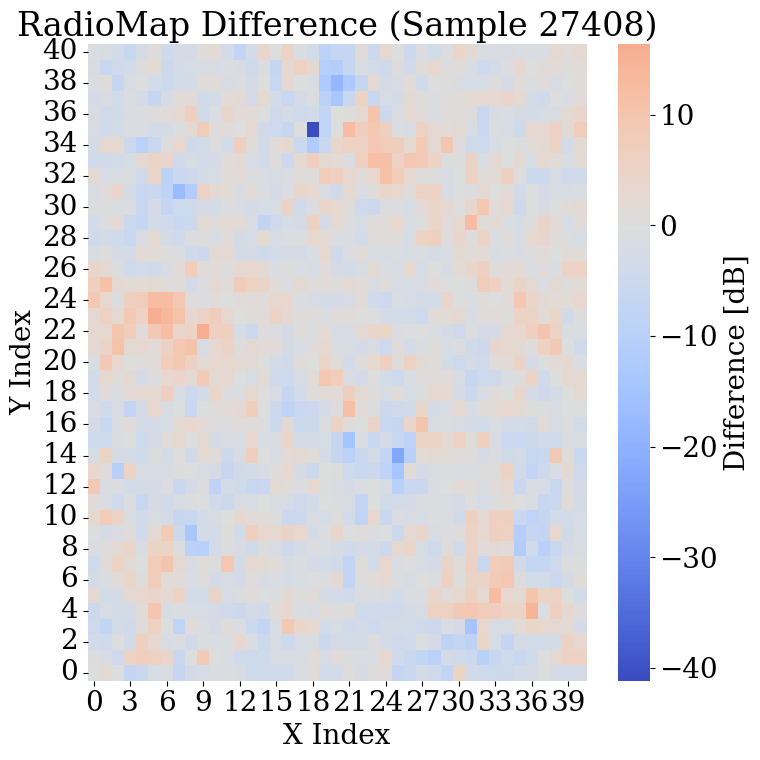

  - Mean Difference: -0.44 dB
  - Max Difference: 41.16 dB

=== Global Analysis for RadioMaps: fspl_RMdataset4 ===

=== Analyzing RadioMap Collection: fspl_RMdataset4 ===
Number of RadioMaps: 30000
Noise Std Dev: 8.0 dB
Resolution: 1

Summary Statistics Across All RadioMaps:
  - Average Number of Transmitters: 10.00
  - Average Number of Jammers: 0.50
  - Overall Mean Power: -30.83 dBm


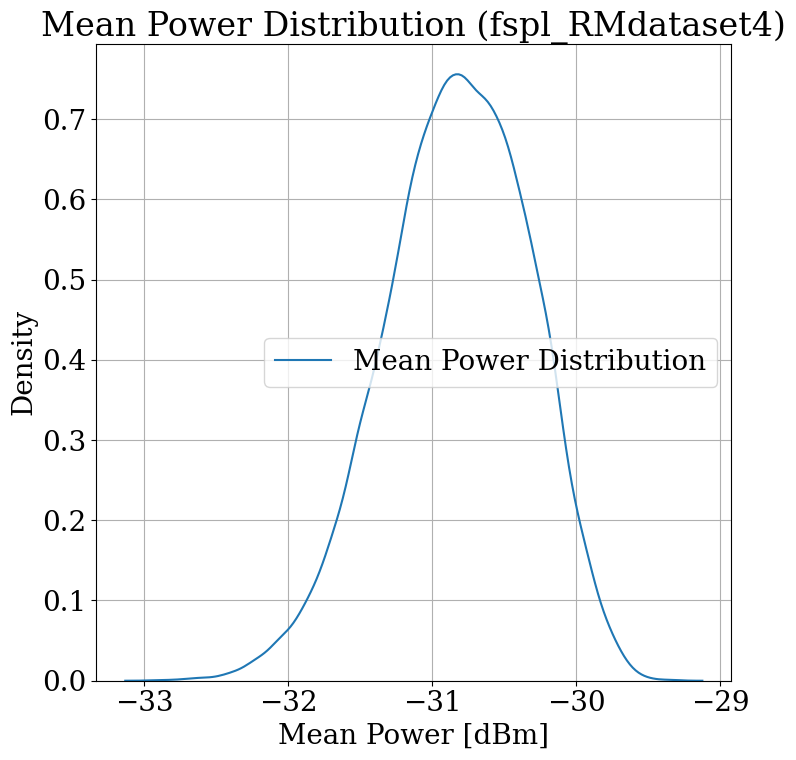


=== Instance-Based Insights for RadioMaps: fspl_RMdataset4 ===

=== Sampling and Comparing RadioMaps (fspl_RMdataset4) ===

--- Sample 15732: Original vs. Digital Twin ---
  - Number of Transmitters: 10
  - Number of Jammers: 1

Original Radio Map:


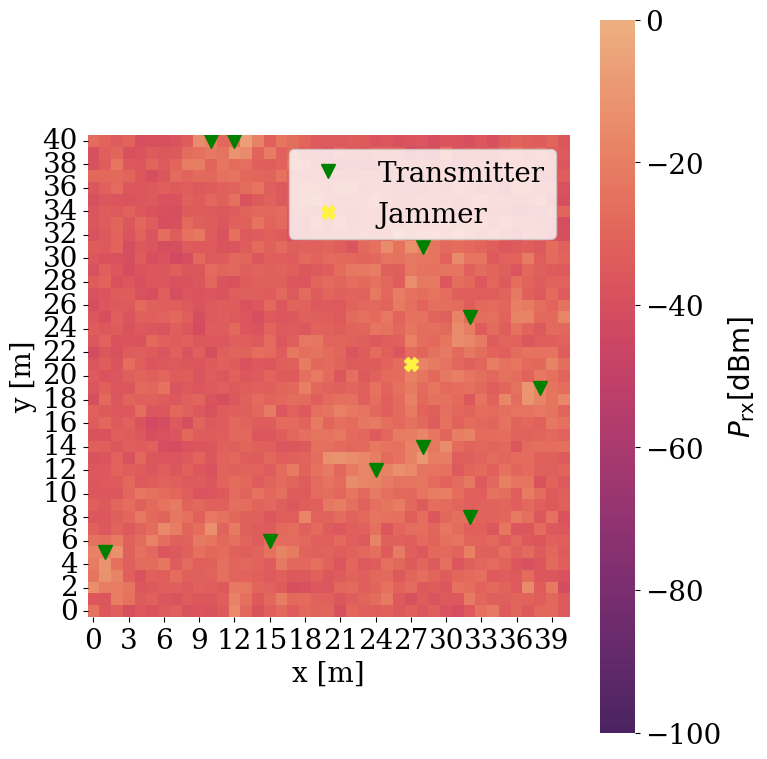


Digital Twin Radio Map:


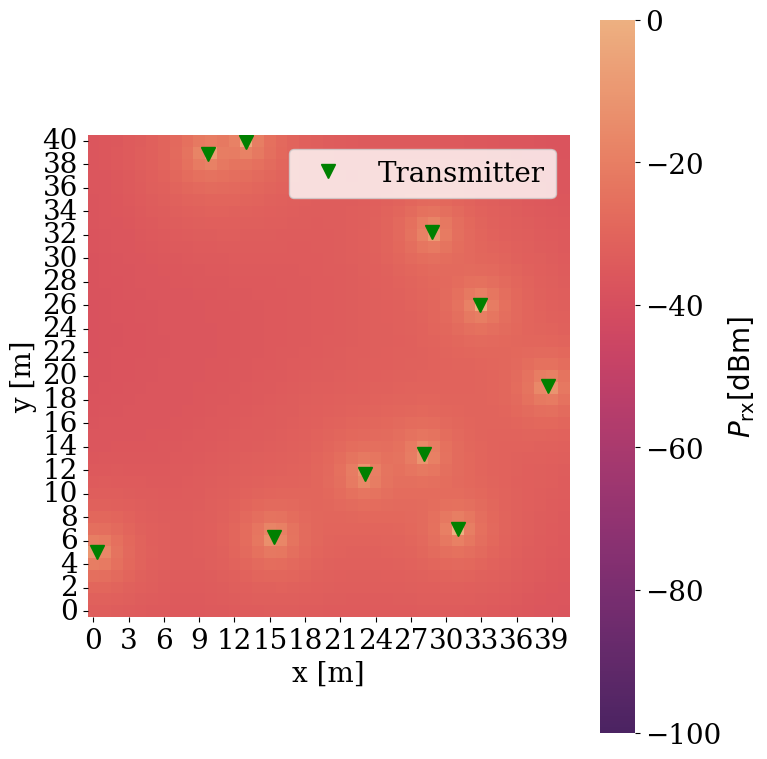


Pairwise Comparison Statistics:

=== Verifying Sample 15732 ===
Original Map: 10 Transmitters, 1 Jammers
Digital Twin Map: 10 Transmitters, 0 Jammers
Transmitter Differences (Position [m], Power [dB]):
  - Position: 0.64 m, Power: 0.00 dB
  - Position: 0.98 m, Power: 0.00 dB
  - Position: 1.34 m, Power: 0.00 dB
  - Position: 1.51 m, Power: 0.00 dB
  - Position: 1.13 m, Power: 0.00 dB
  - Position: 0.47 m, Power: 0.00 dB
  - Position: 0.65 m, Power: 0.00 dB
  - Position: 0.96 m, Power: 0.00 dB
  - Position: 0.68 m, Power: 0.00 dB
  - Position: 1.46 m, Power: 0.00 dB
  - Mean Position Difference: 0.98 m
  - Max Position Difference: 1.51 m
  - Mean Power Difference: 0.00 dB
  - Max Power Difference: 0.00 dB
Radio Map Mean Difference: 1.24 dB
Radio Map Max Difference: 32.81 dB


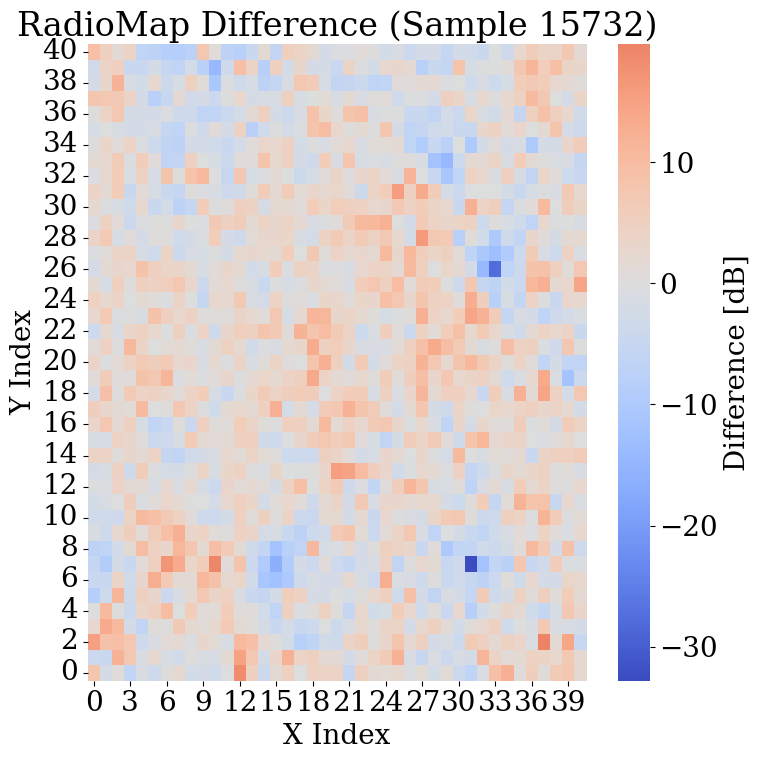

  - Mean Difference: 1.24 dB
  - Max Difference: 32.81 dB

=== Global Analysis for RadioMaps: fspl_RMdataset5 ===

=== Analyzing RadioMap Collection: fspl_RMdataset5 ===
Number of RadioMaps: 30000
Noise Std Dev: 10.0 dB
Resolution: 1

Summary Statistics Across All RadioMaps:
  - Average Number of Transmitters: 10.00
  - Average Number of Jammers: 0.50
  - Overall Mean Power: -28.60 dBm


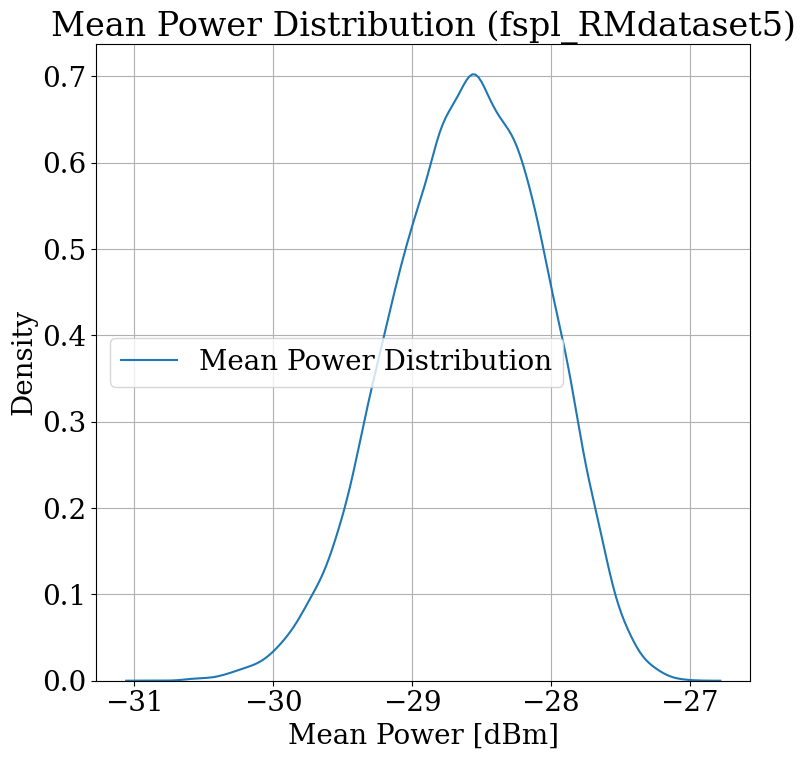


=== Instance-Based Insights for RadioMaps: fspl_RMdataset5 ===

=== Sampling and Comparing RadioMaps (fspl_RMdataset5) ===

--- Sample 28119: Original vs. Digital Twin ---
  - Number of Transmitters: 10
  - Number of Jammers: 0

Original Radio Map:


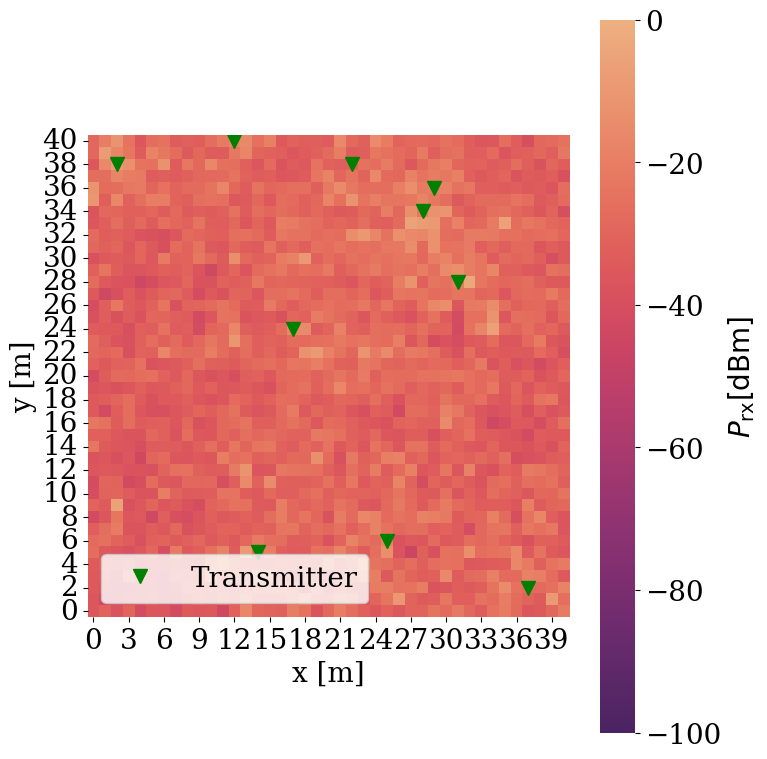


Digital Twin Radio Map:


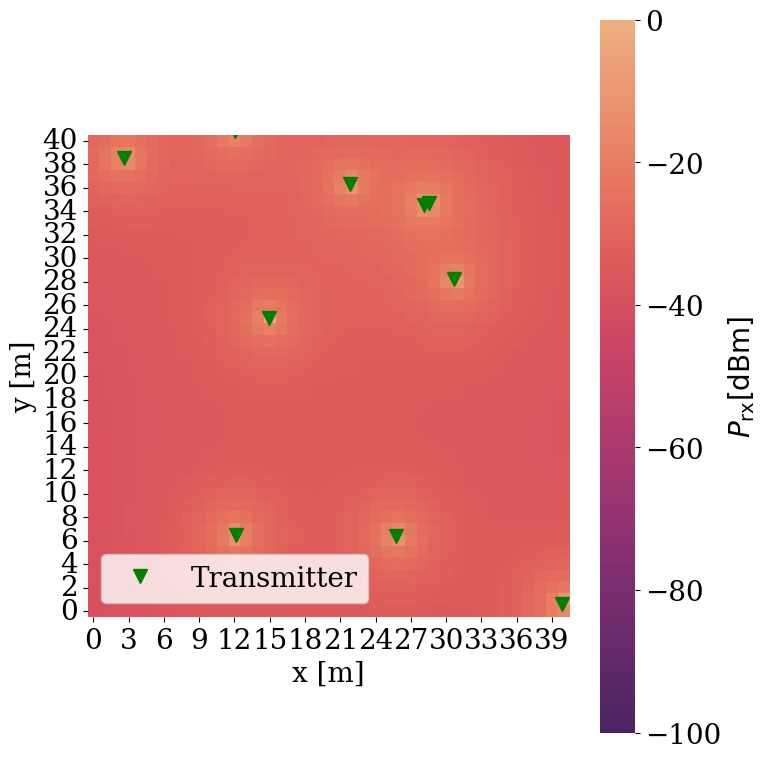


Pairwise Comparison Statistics:

=== Verifying Sample 28119 ===
Original Map: 10 Transmitters, 0 Jammers
Digital Twin Map: 10 Transmitters, 0 Jammers
Transmitter Differences (Position [m], Power [dB]):
  - Position: 1.65 m, Power: 0.00 dB
  - Position: 2.37 m, Power: 0.00 dB
  - Position: 3.20 m, Power: 0.00 dB
  - Position: 0.56 m, Power: 0.00 dB
  - Position: 0.84 m, Power: 0.00 dB
  - Position: 0.84 m, Power: 0.00 dB
  - Position: 0.36 m, Power: 0.00 dB
  - Position: 1.34 m, Power: 0.00 dB
  - Position: 0.82 m, Power: 0.00 dB
  - Position: 2.28 m, Power: 0.00 dB
  - Mean Position Difference: 1.43 m
  - Max Position Difference: 3.20 m
  - Mean Power Difference: 0.00 dB
  - Max Power Difference: 0.00 dB
Radio Map Mean Difference: 2.56 dB
Radio Map Max Difference: 31.45 dB


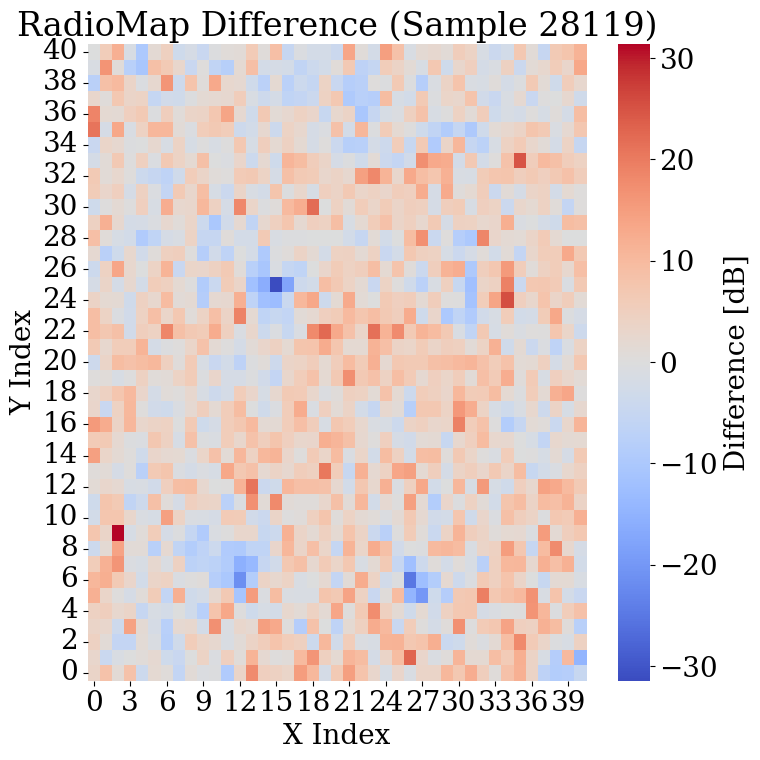

  - Mean Difference: 2.56 dB
  - Max Difference: 31.45 dB

=== Global Analysis for PathLossMaps: fspl_PLdataset0 ===

Analyzing PathLossMapCollection: fspl_PLdataset0
Number of PathLossMaps: 500
PathLossMap 1: Transmitter Position [29, 39], Max Loss: 77.55 dB
PathLossMap 2: Transmitter Position [29, 6], Max Loss: 76.82 dB
PathLossMap 3: Transmitter Position [6, 22], Max Loss: 75.96 dB
PathLossMap 4: Transmitter Position [24, 15], Max Loss: 74.61 dB
PathLossMap 5: Transmitter Position [6, 12], Max Loss: 76.69 dB

=== Instance-Based Insights for PathLossMaps: fspl_PLdataset0 ===

Visualizing PathLossMap Sample 407 (fspl_PLdataset0):
  - Transmitter Position: [15, 40]
  - Max Path Loss: 77.29 dB
  - Min Path Loss: 43.81 dB
  - Mean Path Loss: 70.41 dB
  - Map Shape: (41, 41)

Displaying PathLossMap heatmap...


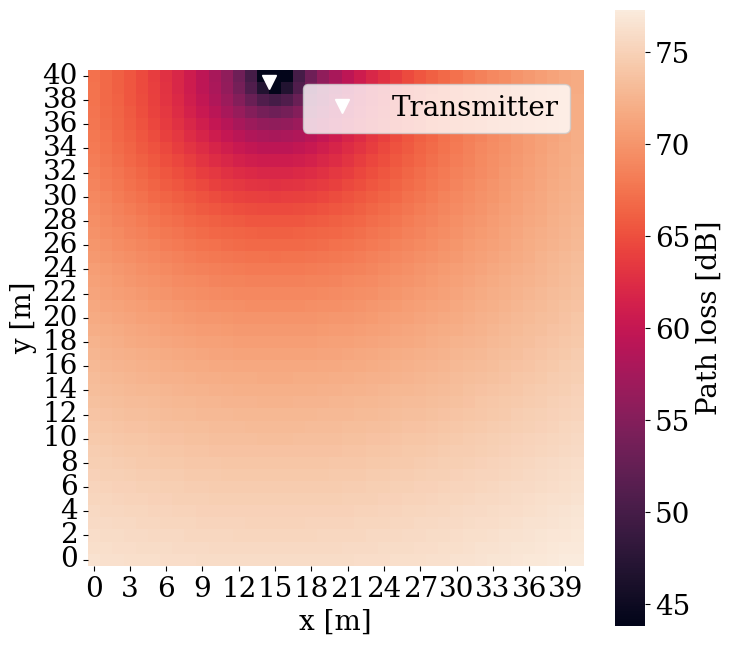


=== Global Analysis for PathLossMaps: fspl_PLdataset1 ===

Analyzing PathLossMapCollection: fspl_PLdataset1
Number of PathLossMaps: 500
PathLossMap 1: Transmitter Position [20, 30], Max Loss: 78.81 dB
PathLossMap 2: Transmitter Position [7, 39], Max Loss: 83.19 dB
PathLossMap 3: Transmitter Position [16, 13], Max Loss: 77.74 dB
PathLossMap 4: Transmitter Position [25, 5], Max Loss: 79.74 dB
PathLossMap 5: Transmitter Position [33, 17], Max Loss: 81.88 dB

=== Instance-Based Insights for PathLossMaps: fspl_PLdataset1 ===

Visualizing PathLossMap Sample 467 (fspl_PLdataset1):
  - Transmitter Position: [35, 12]
  - Max Path Loss: 81.23 dB
  - Min Path Loss: 42.72 dB
  - Mean Path Loss: 69.19 dB
  - Map Shape: (41, 41)

Displaying PathLossMap heatmap...


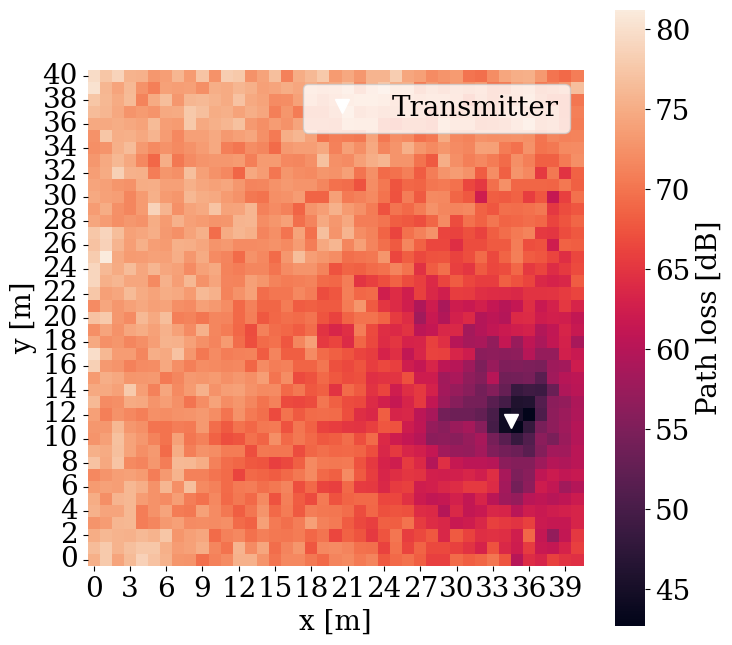


=== Global Analysis for PathLossMaps: fspl_PLdataset2 ===

Analyzing PathLossMapCollection: fspl_PLdataset2
Number of PathLossMaps: 500
PathLossMap 1: Transmitter Position [38, 15], Max Loss: 85.91 dB
PathLossMap 2: Transmitter Position [20, 11], Max Loss: 85.81 dB
PathLossMap 3: Transmitter Position [10, 39], Max Loss: 89.36 dB
PathLossMap 4: Transmitter Position [27, 29], Max Loss: 84.35 dB
PathLossMap 5: Transmitter Position [39, 25], Max Loss: 85.72 dB

=== Instance-Based Insights for PathLossMaps: fspl_PLdataset2 ===

Visualizing PathLossMap Sample 482 (fspl_PLdataset2):
  - Transmitter Position: [7, 17]
  - Max Path Loss: 86.26 dB
  - Min Path Loss: 43.97 dB
  - Mean Path Loss: 67.83 dB
  - Map Shape: (41, 41)

Displaying PathLossMap heatmap...


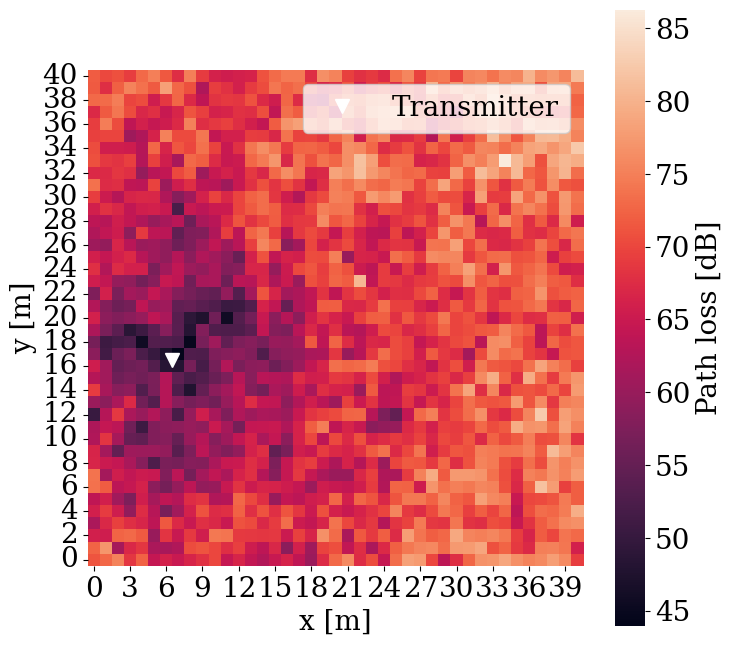


=== Global Analysis for PathLossMaps: fspl_PLdataset3 ===

Analyzing PathLossMapCollection: fspl_PLdataset3
Number of PathLossMaps: 500
PathLossMap 1: Transmitter Position [38, 36], Max Loss: 99.69 dB
PathLossMap 2: Transmitter Position [18, 38], Max Loss: 92.18 dB
PathLossMap 3: Transmitter Position [5, 15], Max Loss: 95.63 dB
PathLossMap 4: Transmitter Position [35, 33], Max Loss: 93.93 dB
PathLossMap 5: Transmitter Position [20, 25], Max Loss: 89.73 dB

=== Instance-Based Insights for PathLossMaps: fspl_PLdataset3 ===

Visualizing PathLossMap Sample 217 (fspl_PLdataset3):
  - Transmitter Position: [29, 2]
  - Max Path Loss: 93.68 dB
  - Min Path Loss: 31.57 dB
  - Mean Path Loss: 70.53 dB
  - Map Shape: (41, 41)

Displaying PathLossMap heatmap...


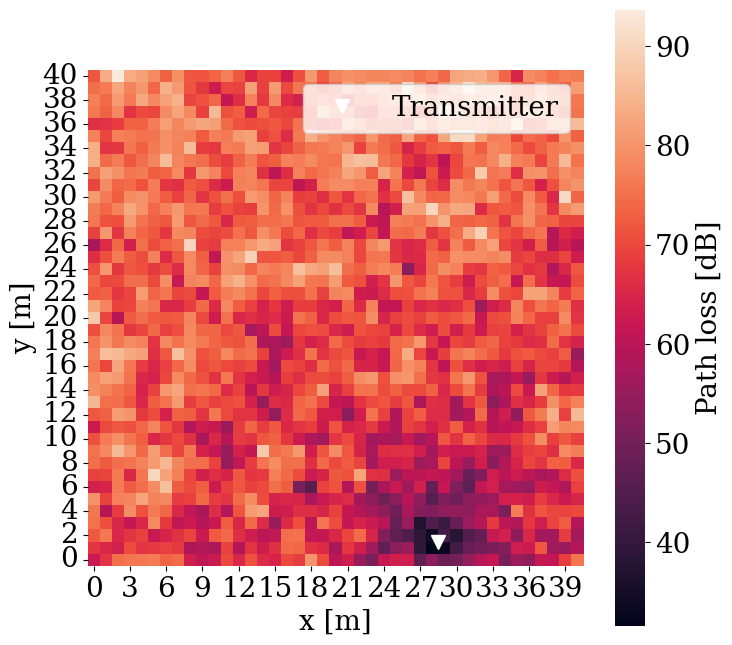


=== Global Analysis for PathLossMaps: fspl_PLdataset4 ===

Analyzing PathLossMapCollection: fspl_PLdataset4
Number of PathLossMaps: 500
PathLossMap 1: Transmitter Position [31, 28], Max Loss: 96.31 dB
PathLossMap 2: Transmitter Position [35, 28], Max Loss: 97.60 dB
PathLossMap 3: Transmitter Position [4, 7], Max Loss: 97.38 dB
PathLossMap 4: Transmitter Position [20, 18], Max Loss: 99.43 dB
PathLossMap 5: Transmitter Position [6, 5], Max Loss: 99.08 dB

=== Instance-Based Insights for PathLossMaps: fspl_PLdataset4 ===

Visualizing PathLossMap Sample 148 (fspl_PLdataset4):
  - Transmitter Position: [21, 24]
  - Max Path Loss: 99.31 dB
  - Min Path Loss: 34.76 dB
  - Mean Path Loss: 67.32 dB
  - Map Shape: (41, 41)

Displaying PathLossMap heatmap...


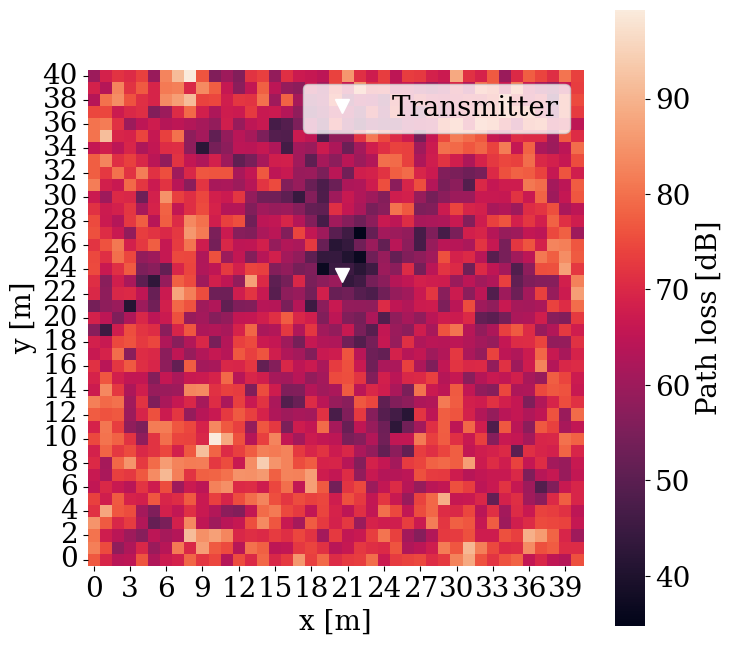


=== Global Analysis for PathLossMaps: fspl_PLdataset5 ===

Analyzing PathLossMapCollection: fspl_PLdataset5
Number of PathLossMaps: 500
PathLossMap 1: Transmitter Position [0, 25], Max Loss: 102.05 dB
PathLossMap 2: Transmitter Position [34, 35], Max Loss: 103.26 dB
PathLossMap 3: Transmitter Position [13, 40], Max Loss: 112.79 dB
PathLossMap 4: Transmitter Position [15, 39], Max Loss: 111.38 dB
PathLossMap 5: Transmitter Position [0, 19], Max Loss: 101.83 dB

=== Instance-Based Insights for PathLossMaps: fspl_PLdataset5 ===

Visualizing PathLossMap Sample 282 (fspl_PLdataset5):
  - Transmitter Position: [21, 35]
  - Max Path Loss: 100.80 dB
  - Min Path Loss: 21.74 dB
  - Mean Path Loss: 68.31 dB
  - Map Shape: (41, 41)

Displaying PathLossMap heatmap...


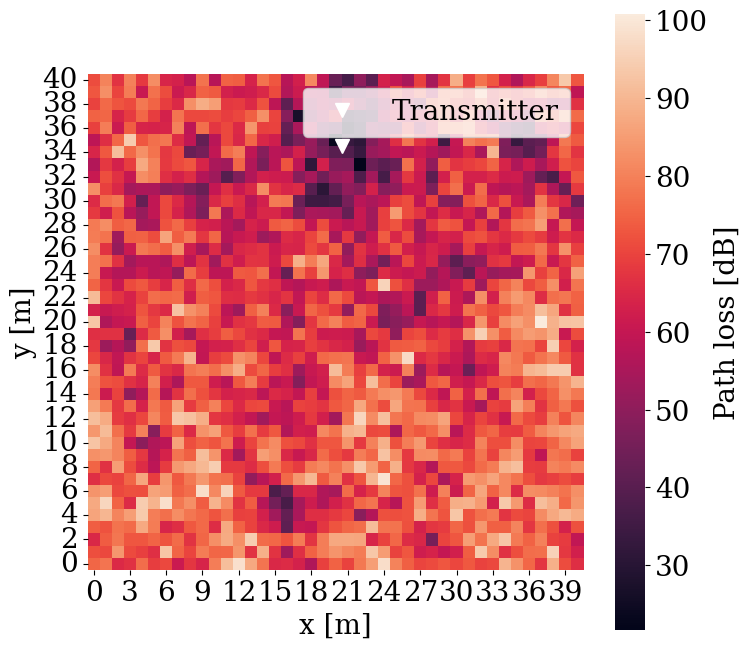

In [38]:
# Define the dataset directory
dataset_dir = os.path.join(module_path, 'datasets')

# File types and filters
file_types = ["measurements", "radiomap", "path_loss"]
#filters = {"noise_std": 6, "grid_size": 10}  # Example filter for measurements files
filters = {"grid_size": 5}
#filters = {"noise_std": 2} 

# Load and process files
all_files_with_metadata = []
for data_type in file_types:
    print(f"Loading {data_type} files...")
    metadata_table = load_metadata_table(data_type=data_type)

    if data_type == "measurements":
        # Apply filtering to measurement files
        filtered_metadata = filter_measurements(metadata_table, filters)
        if not filtered_metadata.empty:
            files_with_metadata = load_files_with_metadata(dataset_dir, filtered_metadata)
            all_files_with_metadata.extend(files_with_metadata)
        else:
            print(f"No {data_type} files match the filters: {filters}")
    else:
        # Process radiomap and path_loss files without filtering
        files_with_metadata = load_files_with_metadata(dataset_dir, metadata_table)
        all_files_with_metadata.extend(files_with_metadata)

# Analyze and visualize
for file_data in all_files_with_metadata:
    obj = file_data['object']
    metadata = file_data['metadata']

    # Truncate the file name to its base name for cleaner output
    truncated_file_name = os.path.basename(metadata['filename'])

    if isinstance(obj, rmu.MeasurementCollection):
        print(f"\n=== Global Analysis for Measurements: {truncated_file_name} ===")
        analyze_measurement_collection(obj, metadata)

        print(f"\n=== Instance-Based Insights for Measurements: {truncated_file_name} ===")
        sample_and_visualize_measurement(obj, metadata)

    elif isinstance(obj, list) and all(isinstance(item, rmu.RadioMap) for item in obj):
        print(f"\n=== Global Analysis for RadioMaps: {truncated_file_name} ===")
        analyze_radio_map_collection(obj, metadata)

        print(f"\n=== Instance-Based Insights for RadioMaps: {truncated_file_name} ===")
        sample_and_compare_radio_maps(obj, metadata, num_samples=1)

    elif isinstance(obj, plu.PathLossMapCollection):
        print(f"\n=== Global Analysis for PathLossMaps: {truncated_file_name} ===")
        analyze_path_loss_collection(obj, metadata, file_data['file_name'])

        print(f"\n=== Instance-Based Insights for PathLossMaps: {truncated_file_name} ===")
        sample_and_visualize_path_loss_map(obj, metadata)

    else:
        print(f"Unknown object type for {truncated_file_name}. Skipping...")
